## Import Packages

In [1]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Utility functions for camera calibration

In [2]:
def find_chessboard_corners(img, rows, cols):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((rows*cols,3), np.float32)
    objp[:,:2] = np.mgrid[0:cols, 0:rows].T.reshape(-1,2)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (cols, rows), None)
    
    if ret == True:
        return objp, corners
    else:
        return None

def calibrate_camera(filenames, rows, cols):
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    img_size = None

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(filenames):
        img = cv2.imread(fname)
        
        # Assume calibration and test images have the same dimensions!
        if img_size is None:
            img_size = (img.shape[1], img.shape[0])

        res = find_chessboard_corners(img, rows, cols)
        if res is not None:   
            objp, corners = res
            objpoints.append(objp)
            imgpoints.append(corners)
        else:
            print(fname)

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    return mtx, dist

## Extract object points and image points for camera calibration

['camera_cal/calibration2.jpg']


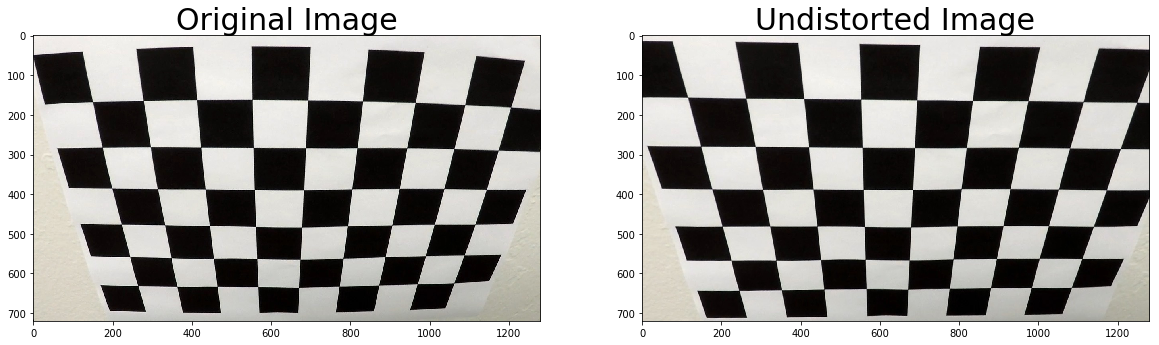

In [3]:
# Define chessboard size
rows = 6
cols = 9

# Make a list of calibration images
#images = glob.glob('camera_cal/calibration*.jpg')
images = ['camera_cal/calibration2.jpg']

print(images)

# Get calibration params
mtx, dist = calibrate_camera(images, rows, cols)

# Test undistortion on an image
#img = cv2.imread('test_images/test1.jpg')
img = cv2.imread('camera_cal/calibration2.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=30)

## Utility functions for filtering an image

In [24]:
def s_select(img, thresh=(150, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary

def sobel_select(img, thresh=(50,100), sobel_kernel=3):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    binary = np.zeros_like(scaled_sobel)
    binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary

def combine_binary(a, b):
    combined = np.zeros_like(a)
    combined[(a == 1) | (b == 1)] = 1
    return combined

## Test combined S channel and Sobel filter

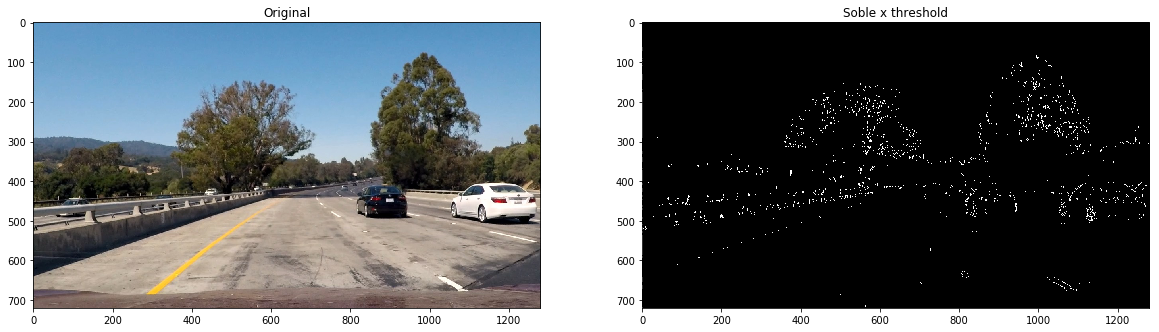

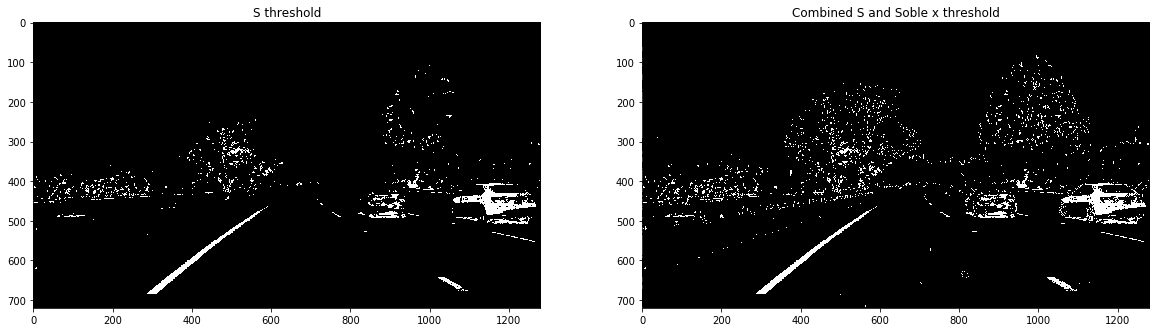

In [25]:
image = cv2.imread('test_images/test1.jpg') 

s_binary = s_select(image)
sobelx_binary = sobel_select(image, thresh=(50,100))
combined_binary = combine_binary(s_binary, sobelx_binary)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original')
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

ax2.set_title('Soble x threshold')
ax2.imshow(sobelx_binary, cmap='gray')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('S threshold')
ax1.imshow(s_binary, cmap='gray')

ax2.set_title('Combined S and Soble x threshold')
ax2.imshow(combined_binary, cmap='gray')

## Utility functions for perspective transform

In [26]:
def src_dst(img):    
    rows = img.shape[0] - 1
    cols = img.shape[1] - 1
    midx = cols // 2
    midy = rows // 2
    # Define 4 source points
    top = 46
    bottom = 470
    height = 270
    boffset = 20
    toffset = 0
    src = [[midx-bottom+boffset,rows],[midx-top+toffset,rows-height],[midx+top+toffset,rows-height],[midx+bottom+boffset,rows]]
    # Define 4 destination points
    width = 350
    dst = [[midx-width,rows],[midx-width,0],[midx+width,0],[midx+width,rows]]
    return src, dst
    
def warp(img, src, dst):
    M = cv2.getPerspectiveTransform(np.array(src, np.float32), np.array(dst, np.float32))
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

def unwarp(img, src, dst):
    M = cv2.getPerspectiveTransform(np.array(dst, np.float32), np.array(src, np.float32))
    img_size = (img.shape[1], img.shape[0])
    unwarped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return unwarped


## Test perspective warp

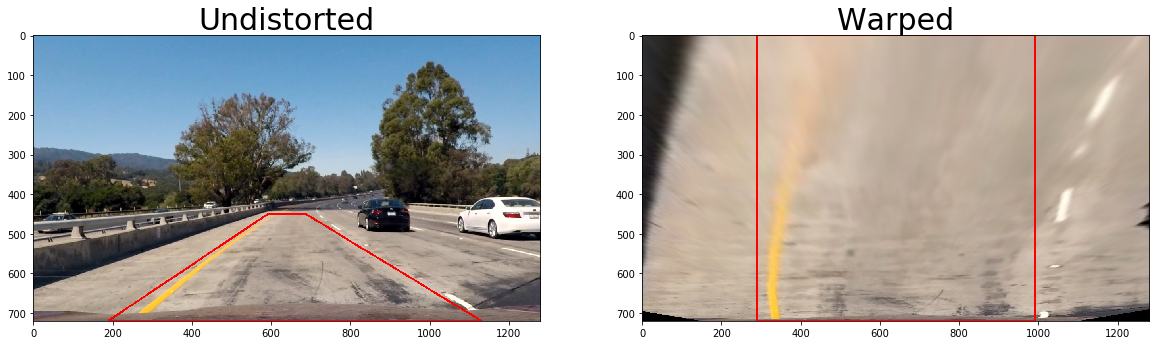

In [27]:
# Read in an image, you can also try test1.jpg or test4.jpg
image = cv2.imread('test_images/test1.jpg') 
converted = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undist = cv2.undistort(converted, mtx, dist, None, mtx)
src, dst = src_dst(undist)
warped = warp(undist, src, dst)

# Draw transform polylines on images
undist_copy = undist.copy()
warped_copy = warped.copy()
cv2.polylines(undist_copy,[np.array(src, np.int32).reshape((-1,1,2))],True,(255,0,0), 4)
cv2.polylines(warped_copy,[np.array(dst, np.int32).reshape((-1,1,2))],True,(255,0,0), 4)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undist_copy)
ax1.set_title('Undistorted', fontsize=30)
ax2.imshow(warped_copy)
ax2.set_title('Warped', fontsize=30)

## Test filter and warp

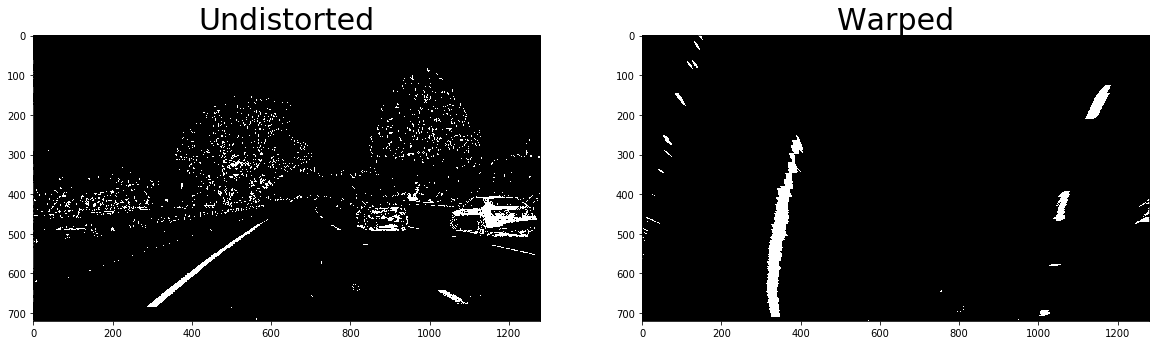

In [28]:
# Read in an image, you can also try test1.jpg or test4.jpg
image = cv2.imread('test_images/test1.jpg') 
converted = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undist = cv2.undistort(converted, mtx, dist, None, mtx)
s_binary = s_select(image)
sobelx_binary = sobel_select(image)
combined_binary = combine_binary(s_binary, sobelx_binary)
src, dst = src_dst(combined_binary)
warped = warp(combined_binary, src, dst)

# Draw transform polylines on images
#cv2.polylines(combined_binary,[np.array(src, np.int32).reshape((-1,1,2))],True,(255,0,0), 4)
#cv2.polylines(warped,[np.array(dst, np.int32).reshape((-1,1,2))],True,(255,0,0), 4)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(combined_binary, cmap='gray')
ax1.set_title('Undistorted', fontsize=30)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Warped', fontsize=30)

## Utility functions for histogram with sliding window

339 1058


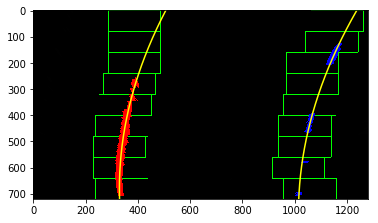

In [40]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    print(leftx_base, rightx_base)

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        # Boundaries of the window
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.mean(nonzerox[good_left_inds]).astype(int)
        if len(good_right_inds) > minpix:
            rightx_current = np.mean(nonzerox[good_right_inds]).astype(int)

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped, vis=False):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    if vis:
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.imshow(out_img)

    return ploty, left_fit, right_fit, left_fitx, right_fitx

ploty, left_fit, right_fit, left_fitx, right_fitx = fit_polynomial(warped, vis=True)

339 1058
1820.78528885 m 1884.41775763 m


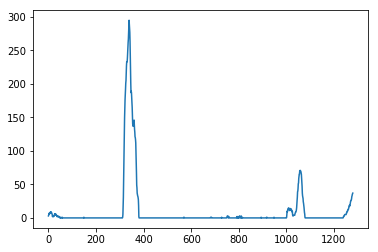

In [35]:
def r_curve(a, b, y):
    return ((1 + (2*a*y + b)**2)**1.5)/np.abs(2*a)
    
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Start by generating our fake example data
# Make sure to feed in your real data instead in your project!
ploty, left_fit_cr, right_fit_cr, left_fitx, right_fitx = fit_polynomial(warped)

# Define y-value where we want radius of curvature
# We'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)

# Implement the calculation of R_curve (radius of curvature)
left_curverad = r_curve(left_fit_cr[0], left_fit_cr[1], y_eval * ym_per_pix)
right_curverad = r_curve(right_fit_cr[0], left_fit_cr[1], y_eval * ym_per_pix)

print(left_curverad, 'm', right_curverad, 'm')

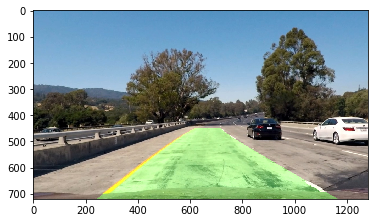

In [36]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = unwarp(color_warp, src, dst)

# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)

In [37]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [41]:
def process_image(image):
    #converted = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    s_binary = s_select(image)
    sobelx_binary = sobel_select(image)
    combined_binary = combine_binary(s_binary, sobelx_binary)
    src, dst = src_dst(combined_binary)
    warped = warp(combined_binary, src, dst)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit polynomial
    ploty, left_fit_cr, right_fit_cr, left_fitx, right_fitx = fit_polynomial(warped)

    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)

    # Implement the calculation of R_curve (radius of curvature)
    left_curverad = r_curve(left_fit_cr[0], left_fit_cr[1], y_eval * ym_per_pix)
    right_curverad = r_curve(right_fit_cr[0], left_fit_cr[1], y_eval * ym_per_pix)

    print(left_curverad, 'm', right_curverad, 'm')# Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = unwarp(color_warp, src, dst)

    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

# image = cv2.imread('test_images/test1.jpg') 
# processed = process_image(image)
# plt.imshow(processed)

output = 'test.mp4'
clip = VideoFileClip('project_video.mp4')
clipout = clip.fl_image(process_image)
%time clipout.write_videofile(output, audio=False)

349 1031
1730.35608915 m 2762.55397513 m
[MoviePy] >>>> Building video test.mp4
[MoviePy] Writing video test.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

349 1031
1730.35608915 m 2762.55397513 m
351 1036
1731.0646689 m 2521.51233286 m


  0%|          | 2/1261 [00:00<02:05, 10.04it/s]

350 1037
1733.84771198 m 2631.56143214 m
352 1037
1723.09609748 m 2648.52450817 m


  0%|          | 4/1261 [00:00<02:00, 10.43it/s]

354 1003
1801.81000581 m 2254.40687078 m


  0%|          | 6/1261 [00:00<01:56, 10.79it/s]

355 1001
1835.67610954 m 2465.61494881 m
356 1005
1933.58399673 m 2126.12132481 m


  1%|          | 8/1261 [00:00<01:52, 11.14it/s]

358 1005
1857.37541473 m 2321.75006807 m


  1%|          | 10/1261 [00:00<01:50, 11.35it/s]

356 1008
2004.20614017 m 2128.82055964 m
356 1025
2129.57248791 m 2285.55722714 m
355 1025
2123.25898416 m 1971.00551461 m


  1%|          | 12/1261 [00:01<01:48, 11.48it/s]

353 1021
2281.98142396 m 2965.47089617 m
354 1032
2305.1146518 m 2279.01244923 m


  1%|          | 14/1261 [00:01<01:47, 11.65it/s]

356 1032
2106.3473616 m 2726.31108636 m


  1%|▏         | 16/1261 [00:01<01:45, 11.81it/s]

354 1030
2122.31837679 m 2452.60071581 m
358 1030
2024.51496714 m 2251.21026708 m
355 1028
2014.05478575 m 2329.21133371 m


  1%|▏         | 18/1261 [00:01<01:44, 11.86it/s]

354 970
1935.37869206 m 2060.16831847 m
354 978
2026.26682335 m 1968.54833019 m


  2%|▏         | 20/1261 [00:01<01:44, 11.91it/s]

352 986
2051.79990097 m 1953.32873366 m


  2%|▏         | 22/1261 [00:01<01:43, 11.94it/s]

353 995
2169.11468718 m 2047.61545764 m
351 1003
2193.42267561 m 2091.13034032 m
314 1006
2174.88551454 m 2045.06373715 m


  2%|▏         | 24/1261 [00:02<01:45, 11.76it/s]

311 1009
2001.26319517 m 2337.62171624 m
326 1011
1933.45771859 m 2081.02432201 m


  2%|▏         | 26/1261 [00:02<01:44, 11.80it/s]

330 1018
1933.91999404 m 2345.13133761 m
334 1025
1930.08696202 m 2261.70304377 m
332 1029
1960.37877804 m 2428.4583517 m


  2%|▏         | 28/1261 [00:02<01:46, 11.62it/s]

339 1028


  2%|▏         | 30/1261 [00:02<01:52, 10.95it/s]

1842.68670526 m 2104.76075641 m
336 1027
1687.60848905 m 2899.23027149 m
336 994


  3%|▎         | 32/1261 [00:02<01:53, 10.78it/s]

1650.19667457 m 2018.10108694 m
338 987
1631.45020783 m 2025.77927302 m
335 997
1645.63211838 m 2887.43435663 m


  3%|▎         | 34/1261 [00:02<01:52, 10.94it/s]

336 1000
1647.25677575 m 1810.15901765 m
338 1003
1613.44304532 m 2061.82721309 m
340 1006
1614.01193138 m 2183.63717908 m


  3%|▎         | 38/1261 [00:03<01:48, 11.22it/s]

342 1011
1642.27839747 m 1854.87990467 m
343 1010
1663.6714871 m 1968.95377221 m
344 1014
1672.12532098 m 1975.69681336 m


  3%|▎         | 42/1261 [00:03<01:46, 11.40it/s]

344 955
1679.28122878 m 1959.71516242 m
345 1021
1714.58253299 m 1883.29649603 m
346 1022
1748.06309493 m 1969.5285306 m


  3%|▎         | 44/1261 [00:03<01:48, 11.17it/s]

347 962
1805.61457261 m 2185.69049957 m
346 981
1851.23772988 m 1900.70177982 m
346 990
1926.27251289 m 1911.4534267 m


  4%|▍         | 48/1261 [00:04<01:46, 11.41it/s]

346 990
1981.84947971 m 1742.37878969 m
345 1001
1997.85471945 m 2196.25145891 m
346 1005
2038.66197759 m 2024.44704729 m


  4%|▍         | 50/1261 [00:04<01:43, 11.69it/s]

346 1009
2237.40168486 m 1891.72362194 m
346 1014
2214.09278327 m 1660.21521665 m
347 1018
2228.04213394 m 1887.84886551 m


  4%|▍         | 54/1261 [00:04<01:40, 11.97it/s]

347 1018
2173.15565689 m 1930.42997604 m
347 1022
2077.6283841 m 2164.75356865 m
347 955
2234.05955603 m 2181.33303194 m


  4%|▍         | 56/1261 [00:04<01:39, 12.05it/s]

347 967
2288.10485399 m 2288.85513481 m
346 972
2173.14469508 m 2245.26456387 m
346 982
2234.05999728 m 1861.18688738 m


  5%|▍         | 60/1261 [00:05<01:37, 12.29it/s]

345 982
2226.26755998 m 1894.63851475 m
345 991
2086.41423309 m 2059.41922727 m
346 989
2101.78410508 m 2069.17093331 m


  5%|▍         | 62/1261 [00:05<01:37, 12.36it/s]

346 986
1970.21032081 m 1831.4593415 m
344 996
1995.7623902 m 1994.10879707 m
343 997
1998.96613172 m 1910.63284845 m


  5%|▌         | 66/1261 [00:05<01:37, 12.30it/s]

336 1001
1912.11478053 m 2074.67202929 m
338 1005
2034.18123338 m 2140.4376304 m
338 938
1934.14595149 m 1525.59543415 m


  5%|▌         | 68/1261 [00:05<01:36, 12.30it/s]

337 1011
1960.43474854 m 1509.16998354 m
335 956
2003.68167818 m 1628.8381572 m
334 950
1968.97379042 m 1699.42809681 m


  6%|▌         | 72/1261 [00:06<01:35, 12.45it/s]

333 956
2139.25804534 m 1875.15664182 m
331 967
2140.61179944 m 1123.14273733 m
330 971
2138.41864618 m 1153.95668846 m


  6%|▌         | 74/1261 [00:06<01:35, 12.43it/s]

329 971
2143.98580113 m 1955.43798028 m
329 975
2191.2579858 m 1360.66776472 m
328 982
2268.5268421 m 1184.82983442 m


  6%|▌         | 78/1261 [00:06<01:36, 12.27it/s]

328 985
2247.18459331 m 1405.1334263 m
327 992
2431.96761102 m 1424.63809999 m
326 1000
2452.60593932 m 1494.68777021 m


  6%|▋         | 80/1261 [00:06<01:36, 12.18it/s]

325 1005
2497.44789819 m 1582.1859483 m
324 952
2365.6492724 m 1673.54200668 m
323 973
2275.6029807 m 1988.70918672 m


  7%|▋         | 82/1261 [00:06<01:42, 11.55it/s]

291 977
2163.77248952 m 2307.2932539 m
319 978
2140.13951964 m 1464.61148755 m
294 977
2217.13838385 m 1500.77730631 m


  7%|▋         | 86/1261 [00:07<01:41, 11.56it/s]

298 982
2103.20537399 m 1563.73242764 m
311 983
2003.7221227 m 1964.36311735 m
313 983
1834.64453651 m 1657.83959319 m


  7%|▋         | 88/1261 [00:07<01:39, 11.75it/s]

311 986
1729.16770625 m 1834.37793253 m
313 985
1647.47455821 m 1741.54597437 m
317

  7%|▋         | 90/1261 [00:07<01:46, 11.02it/s]

 987
1555.93944172 m 1940.5529939 m
316 946
1590.45550137 m 1633.83320606 m
317 941
1605.53918072 m 1676.82408231 m


  7%|▋         | 94/1261 [00:08<01:43, 11.25it/s]

321 943
1564.06348818 m 1727.78431498 m
319 948
1548.93470046 m 1890.53346922 m
322 956
1575.17054535 m 1853.03219588 m


  8%|▊         | 96/1261 [00:08<01:40, 11.57it/s]

320 960
1598.27754829 m 1646.32523284 m
321 965
1604.05794994 m 1453.15454825 m
320

  8%|▊         | 100/1261 [00:08<01:45, 11.05it/s]

 972
1642.80317717 m 1500.27873922 m
322 978
1642.73327668 m 1444.58785002 m
322 980
1666.23439196 m 1382.53624436 m


  8%|▊         | 102/1261 [00:08<01:44, 11.09it/s]

324 983
1623.2096225 m 1526.14660138 m
325 983
1595.24648166 m 1539.3625143 m
326 989
1593.09374408 m 1700.9008264 m


  8%|▊         | 106/1261 [00:09<01:41, 11.43it/s]

328 994
1601.81862326 m 1824.06429275 m
326 957
1638.62500483 m 1826.5859176 m
327 982
1678.41288646 m 1686.2233612 m


  9%|▊         | 108/1261 [00:09<01:37, 11.82it/s]

328 974
1721.45739496 m 1752.75682649 m
330 980
1644.43818509 m 1432.00737934 m
330 980
1643.42862799 m 1314.06498298 m


  9%|▉         | 112/1261 [00:09<01:40, 11.47it/s]

329 991
1646.17425216 m 1295.82763107 m
330 994
1637.40411764 m 1329.59050288 m
329 1005
1682.01135662 m 1427.73219746 m


  9%|▉         | 114/1261 [00:09<01:37, 11.76it/s]

331 1007
1624.14843565 m 1456.7697562 m
332 1005
1625.16490727 m 1473.84801474 m
334 1009
1597.98022326 m 1593.35153227 m


  9%|▉         | 118/1261 [00:10<01:33, 12.20it/s]

335 1011
1591.20557264 m 1633.56004929 m
335 1010
1603.44976277 m 1407.41348121 m
337 981
1608.35731016 m 1516.20346563 m


 10%|▉         | 120/1261 [00:10<01:34, 12.11it/s]

338 984
1640.64171043 m 1430.79446586 m
339 984
1623.50792626 m 1566.91003284 m
340 993
1655.97445721 m 1354.97482942 m


 10%|▉         | 124/1261 [00:10<01:34, 12.01it/s]

343 984
1671.28010156 m 1508.60071225 m
345 987
1668.54328946 m 1564.01147116 m
344 991
1656.01360615 m 1540.74447072 m


 10%|▉         | 126/1261 [00:10<01:33, 12.08it/s]

346 994
1664.22849414 m 1584.44287617 m
345 1001
1749.68637632 m 1592.47488043 m
346 1006
1741.08165725 m 1825.43926495 m


 10%|█         | 130/1261 [00:11<01:31, 12.34it/s]

347 1011
1780.21429092 m 1776.39962435 m
353 1011
1768.97461287 m 1673.92364747 m
349 1018
1817.41846256 m 1799.2407095 m


 10%|█         | 132/1261 [00:11<01:31, 12.34it/s]

349 972
1798.33145982 m 1808.66646009 m
353 975
1828.22805372 m 1813.02470683 m
352 986
1850.24358372 m 1858.56534008 m


 11%|█         | 136/1261 [00:11<01:31, 12.31it/s]

354 990
1908.30087258 m 2589.87629574 m
355 994
1879.08468436 m 3216.50698953 m
355 1003
1875.45899779 m 1703.67006241 m


 11%|█         | 138/1261 [00:11<01:30, 12.41it/s]

355 1004
2007.75396292 m 1871.04228541 m
354 1023
2029.06526376 m 1782.07425157 m
353 1018
2010.22352983 m 2154.1506239 m


 11%|█▏        | 142/1261 [00:12<01:29, 12.49it/s]

350 1024
2086.89855779 m 2088.8250901 m
350 1028
2035.87562987 m 2080.09697018 m
351 972
2102.37174041 m 2204.54612341 m


 11%|█▏        | 144/1261 [00:12<01:29, 12.47it/s]

351 1029
1991.09911416 m 1803.46647815 m
351 983
1992.71525986 m 1799.55360261 m
349 980
1947.41017156 m 1764.83977617 m


 12%|█▏        | 146/1261 [00:12<01:32, 12.09it/s]

349 984
1837.54715337 m 1644.41160963 m
348 989
1882.69377932 m 1571.1241422 m
350 990


 12%|█▏        | 150/1261 [00:12<01:35, 11.59it/s]

1723.28922056 m 1428.99127309 m
350 996
1708.20439711 m 1629.36600091 m
350 1011
1772.93872249 m 1663.67465322 m
350 1010
1804.51923935 m 1647.93723908 m


 12%|█▏        | 154/1261 [00:13<01:35, 11.55it/s]

348 1013
1836.56968534 m 1719.3456761 m
349 1011
1816.40799911 m 1827.20550665 m
347 1021
1900.4023963 m 2146.0836222 m


 12%|█▏        | 156/1261 [00:13<01:36, 11.49it/s]

345 1025
1888.03972864 m 2116.13596093 m
345 991
1880.26754638 m 2325.63248728 m
345 994
1853.93315023 m 1575.09729043 m


 13%|█▎        | 158/1261 [00:13<01:36, 11.47it/s]

344 983
1774.92469712 m 1754.6755897 m
340 995
1821.94741065 m 2204.21611853 m
340 990
1787.18150513 m 2763.8528096 m


 13%|█▎        | 162/1261 [00:13<01:34, 11.57it/s]

338 1009
1859.75974938 m 1856.98919994 m
336 1013
1850.63296719 m 1768.62385121 m
335 1020
1917.17074727 m 1841.84570663 m


 13%|█▎        | 164/1261 [00:14<01:37, 11.21it/s]

333 1019
1820.87531746 m 1741.47605011 m
335 1019
1764.30894586 m 1603.72996692 m
334 1015


 13%|█▎        | 166/1261 [00:14<01:41, 10.75it/s]

1777.42845258 m 1993.44943845 m
335 1017
1726.29395432 m 1386.20633097 m
335 971
1847.25950637 m 1853.45262378 m


 13%|█▎        | 170/1261 [00:14<01:42, 10.69it/s]

333 979
1908.68854014 m 1288.26741641 m
330 977
1934.68858132 m 1226.37194679 m
330 982
1942.73648344 m 960.411381259 m


 14%|█▎        | 172/1261 [00:14<01:42, 10.68it/s]

328 980
1872.67842935 m 970.422100314 m
328 979
1857.6670513 m 1156.87503549 m


 14%|█▍        | 174/1261 [00:14<01:46, 10.22it/s]

328 983
1740.76808103 m 980.143077695 m
330 985
1733.18612586 m 1195.37516416 m


 14%|█▍        | 177/1261 [00:15<01:50,  9.77it/s]

327 989
1694.06015411 m 1278.09665375 m
326 998
1765.04809622 m 1141.63468521 m
325 1009


 14%|█▍        | 179/1261 [00:15<01:52,  9.66it/s]

1759.52207057 m 1030.00492084 m
326 1013
1738.24864245 m 1061.84195986 m


 14%|█▍        | 180/1261 [00:15<01:52,  9.58it/s]

319 974
1711.45048845 m 1401.94925029 m
325 979
1643.08466933 m 1345.43006384 m
321 984


 15%|█▍        | 183/1261 [00:15<01:59,  9.03it/s]

1648.63154984 m 1419.43608924 m
323 992
1622.35413189 m 1442.94064976 m


 15%|█▍        | 185/1261 [00:16<01:52,  9.59it/s]

324 997
1582.4578025 m 1414.69867188 m
324 998
1552.74088584 m 1455.70615246 m
326 995
1523.30810003 m 1855.30752813 m


 15%|█▍        | 187/1261 [00:16<01:47,  9.99it/s]

325 1001
1531.24270634 m 1511.56323394 m
329 996
1540.67299393 m 1615.0641008 m
332 1004
1547.0964267 m 1567.03222279 m


 15%|█▌        | 191/1261 [00:16<01:42, 10.48it/s]

334 1009
1565.56877484 m 1714.81835824 m
337 1018
1578.77646439 m 1885.52646926 m
338 1020
1601.00717013 m 1930.66921943 m


 15%|█▌        | 193/1261 [00:16<01:45, 10.15it/s]

341 952
1602.0113933 m 2179.7022266 m
342 960
1619.65116851 m 2151.43815168 m
343

 16%|█▌        | 197/1261 [00:17<01:41, 10.53it/s]

 970
1633.34655116 m 1517.64682642 m
340 981
1730.85678098 m 1552.78995526 m
335 998
1819.88510393 m 1695.78198116 m


 16%|█▌        | 199/1261 [00:17<01:40, 10.52it/s]

333 1015
1953.02195091 m 1546.18356386 m
329 1011
2119.99475161 m 1854.72283949 m
329 1012
2040.28694404 m 1694.94989483 m


 16%|█▌        | 201/1261 [00:17<01:41, 10.45it/s]

328 1016
2030.79717968 m 1809.69788911 m
326 1015
1965.71589044 m 1720.75279444 m


 16%|█▌        | 203/1261 [00:17<01:44, 10.11it/s]

325 1019
1931.89386253 m 1651.8642907 m
323 1022
1884.38266577 m 1795.3003424 m


 16%|█▋        | 205/1261 [00:18<01:46,  9.96it/s]

324 971
1827.89868999 m 1792.42348515 m
325 972
1807.676009 m 1833.27059741 m


 16%|█▋        | 208/1261 [00:18<01:50,  9.56it/s]

328 973
1705.08041088 m 1749.57825821 m
330 978
1680.47079182 m 2025.61421942 m


 17%|█▋        | 210/1261 [00:18<01:47,  9.75it/s]

330 985
1713.5935383 m 1789.1285741 m
329 992
1746.18688166 m 2411.99705563 m
328

 17%|█▋        | 212/1261 [00:18<01:49,  9.60it/s]

 1001
1846.12741123 m 1996.98577613 m
328 1000
1805.31993847 m 1986.21292484 m
327 1008


 17%|█▋        | 214/1261 [00:19<01:47,  9.74it/s]

1832.69062555 m 1989.09614376 m
327 1016
1826.55128508 m 2169.35586217 m
326 1017
1815.06418165 m 2282.21188026 m


 17%|█▋        | 216/1261 [00:19<01:47,  9.73it/s]

324 1017
1849.48757387 m 2535.12222614 m
324 1015
1860.85148617 m 2725.56993217 m
322 962
1939.49600724

 17%|█▋        | 219/1261 [00:19<01:46,  9.81it/s]

 m 2185.47064118 m
322 963
1915.8654139 m 2027.37209951 m
320 973
1980.62390996 m 1894.59412802 m
322 973


 18%|█▊        | 221/1261 [00:19<01:44,  9.96it/s]

2015.69671836 m 2260.29538665 m
322 980


 18%|█▊        | 223/1261 [00:20<02:13,  7.79it/s]

2085.77825042 m 2035.6195763 m
323 987
2125.0223168 m 1938.76383467 m


 18%|█▊        | 225/1261 [00:20<02:03,  8.42it/s]

326 989
2014.97216139 m 1886.81395769 m
324 986
2076.04068349 m 1936.58981172 m
322 995


 18%|█▊        | 227/1261 [00:20<01:53,  9.09it/s]

1939.03263054 m 1940.91025272 m
323 996
2040.63152087 m 1970.05857584 m
321 938


 18%|█▊        | 228/1261 [00:20<01:51,  9.25it/s]

2088.82538795 m 2056.51407679 m
319 932
2042.57173235 m 1568.26016065 m


 18%|█▊        | 230/1261 [00:20<02:15,  7.58it/s]

316 941
2159.68677987 m 1606.8519191 m
316 944
2141.97545002 m 1415.29010982 m
314 965
2184.105946 m 1271.32440642 m


 19%|█▊        | 234/1261 [00:21<01:52,  9.12it/s]

313 955
2158.5629646 m 1232.75380101 m
311 961
2132.22406321 m 1089.37260797 m
309 966
2044.92184632 m 1102.64401327 m


 19%|█▊        | 236/1261 [00:21<01:46,  9.59it/s]

309 965
1984.42403037 m 1245.92044363 m
308 979
1957.57368091 m 1306.3728404 m
308 972
1902.78568053 m 1434.05915716 m


 19%|█▉        | 240/1261 [00:21<01:38, 10.41it/s]

306 977
1846.80060482 m 1292.07402523 m
305 986
1847.68777567 m 1404.74824841 m
305 982
1833.86612185 m 1418.04425846 m


 19%|█▉        | 242/1261 [00:21<01:36, 10.53it/s]

301 938
1891.11851954 m 1393.23191356 m
302 939
1794.95448602 m 1602.88724131 m
300 950
1875.16089491 m 1492.38227959 m


 20%|█▉        | 246/1261 [00:22<01:33, 10.87it/s]

300 943
1812.90888509 m 1405.94963328 m
299 953
1789.960177 m 1406.48482987 m
299 952
1836.78727578 m 1413.73911837 m


 20%|█▉        | 248/1261 [00:22<01:37, 10.37it/s]

302 961
1757.72428031 m 1470.76368904 m
297 965
1848.37390177 m 1562.76353898 m
297

 20%|█▉        | 250/1261 [00:22<01:38, 10.29it/s]

 970
1767.17112536 m 1322.30163971 m
296 973
1807.30726797 m 1296.20288975 m


 20%|█▉        | 252/1261 [00:22<01:41,  9.96it/s]

296 977
1838.35750369 m 1383.05744672 m
297 980
1806.07543664 m 1474.01841595 m
297 939
1928.53339485 m 1368.58206984 m


 20%|██        | 256/1261 [00:23<01:35, 10.49it/s]

297 939
1848.51051465 m 1475.21079901 m
297 946
1804.81542835 m 1357.32015131 m
299 947


 20%|██        | 258/1261 [00:23<01:35, 10.47it/s]

1734.24442726 m 1148.03784065 m
300 950
1777.40957378 m 1146.98917426 m
299 959
1729.57688517 m 1233.11484005 m


 21%|██        | 260/1261 [00:23<01:35, 10.43it/s]

302 970
1720.89810586 m 1260.00235628 m
300 964
1827.61697398 m 1343.66102833 m
302 982
1753.95026268 m 1529.35437666 m


 21%|██        | 264/1261 [00:24<01:32, 10.73it/s]

303 976
1750.68976173 m 1657.63225514 m
303 983
1758.96338575 m 1286.47679479 m
303 984
1796.58833514 m 1382.92024803 m


 21%|██        | 266/1261 [00:24<01:32, 10.73it/s]

301 992
1837.25510806 m 1816.0524977 m
303 970
1810.83939686 m 1458.93837744 m
301 977
1832.93575386 m 1534.21865329 m


 21%|██▏       | 270/1261 [00:24<01:32, 10.66it/s]

298 982
1901.02062752 m 1491.9304173 m
298 989
1919.61499538 m 1464.79284254 m
301 985


 22%|██▏       | 272/1261 [00:24<01:33, 10.58it/s]

1946.68915592 m 1382.93694909 m
303 986
1851.91320953 m 1457.76068166 m
304 988
1930.66689442 m 1669.71849366 m


 22%|██▏       | 274/1261 [00:24<01:33, 10.58it/s]

307 988
1867.92850837 m 1892.63370986 m
307 989
1937.31939009 m 2030.10346519 m
307 994


 22%|██▏       | 276/1261 [00:25<01:34, 10.47it/s]

2001.24594868 m 2139.90979147 m
307 997
2067.43271109 m 1655.78529059 m
307 978
2160.31231812 m 2102.61990749 m


 22%|██▏       | 280/1261 [00:25<01:36, 10.21it/s]

309 977
2174.06622349 m 1607.32541479 m
311 979
2189.45611864 m 1552.41492969 m
312 988


 22%|██▏       | 282/1261 [00:25<01:35, 10.25it/s]

2380.7164515 m 1652.67519931 m
315 988
2291.49249282 m 1412.79272266 m
314 981
2460.82752146 m 1404.17413542 m


 23%|██▎       | 284/1261 [00:25<01:37, 10.04it/s]

318 984
2327.79946851 m 1709.1449839 m
317 996
2580.49979549 m 1646.72024639 m
316 1005


 23%|██▎       | 286/1261 [00:26<01:35, 10.19it/s]

2556.51466628 m 1605.86217859 m
318 983
2438.30982926 m 1700.32921484 m
318 1000
2565.68836899 m 1734.63899298 m


 23%|██▎       | 290/1261 [00:26<01:32, 10.54it/s]

321 991
2462.45631341 m 1851.11043462 m
320 1005
2804.68432353 m 1694.03614885 m
327 1001
2591.05250213 m 1835.61886724 m


 23%|██▎       | 292/1261 [00:26<01:32, 10.52it/s]

330 982
2719.55868845 m 1792.70386767 m
329 990
2864.15348551 m 1703.56387675 m
331

 23%|██▎       | 294/1261 [00:26<01:33, 10.34it/s]

 1008
2633.2664353 m 1916.51327534 m
328 1000
2590.75237508 m 1821.31154214 m
331 1002


 23%|██▎       | 296/1261 [00:27<01:34, 10.18it/s]

2795.23717026 m 1992.91529976 m
331 1008
2899.53856629 m 2305.21687043 m
329 1005
2759.31300408 m 2212.87589142 m


 24%|██▍       | 300/1261 [00:27<01:35, 10.08it/s]

328 1014
2947.86133082 m 2879.77691322 m
326 994
2931.08073926 m 3095.19332094 m
327 995


 24%|██▍       | 302/1261 [00:27<01:37,  9.87it/s]

2690.53981623 m 3279.44710622 m
324 1010
2710.8520318 m 2742.6810184 m


 24%|██▍       | 303/1261 [00:27<01:37,  9.81it/s]

323 1010
3057.13746592 m 4122.42360452 m
323 987
3319.26862009 m 6262.10972387 m
321 991
3158.47975651 m 36383.5697305 m


 24%|██▍       | 307/1261 [00:28<01:34, 10.07it/s]

324 989
5030.65551647 m 7022.47970956 m
323 1007
4082.44409988 m 10921.4535119 m
331 1002


 25%|██▍       | 309/1261 [00:28<01:34, 10.02it/s]

6365.7504535 m 3564.91282627 m
331 1000
4133.91049598 m 3746.65300453 m


 25%|██▍       | 311/1261 [00:28<01:35,  9.93it/s]

333 1009
4067.78872011 m 3352.08812892 m
335 1011
9438.41752814 m 3463.90455731 m
337 986
8538.87216532

 25%|██▍       | 313/1261 [00:28<01:33, 10.18it/s]

 m 6226.83319882 m
343 1010
7626.09359567 m 4150.17724722 m
343 973
8722.74236553 m 3851.75611127 m
342 983


 25%|██▍       | 315/1261 [00:29<01:33, 10.13it/s]

10677.5739622 m 3208.88573124 m
341 989
10224.2644973 m 2735.33472939 m
341 1004
9861.90547736 m 1687.95912738 m


 25%|██▌       | 319/1261 [00:29<01:35,  9.91it/s]

346 993
7918.33945298 m 2190.17124654 m
346 1006
9857.6085559 m 2312.69625726 m
349 991


 25%|██▌       | 321/1261 [00:29<01:34,  9.99it/s]

8037.93214928 m 3068.22153015 m
350 1000
7408.74000234 m 4064.48222258 m
350 1002
7567.72290827 m 2997.27908409 m


 26%|██▌       | 325/1261 [00:29<01:27, 10.75it/s]

350 1006
8721.1613792 m 3495.76165436 m
346 1016
8930.5502487 m 4351.50170532 m
350 1009
10174.0092091 m 4587.18100242 m


 26%|██▌       | 327/1261 [00:30<01:25, 10.94it/s]

350 1018
10251.8739984 m 4483.34621474 m
346 1012
7618.41381913 m 6928.53122823 m
346 1018
7081.40801936 m 12554.5035009 m


 26%|██▌       | 329/1261 [00:30<01:24, 10.98it/s]

342 1014
10927.6488528 m 16180.279486 m
345 1009
9298.47329286 m 14024.5918875 m
350 1023
56271.7456418 m 5923.81126628 m


 26%|██▋       | 333/1261 [00:30<01:22, 11.20it/s]

356 1005
16845.6988284 m 8421.98140317 m
356 998
12271.634747 m 6761.24339247 m
355 1001
12338.0902117 m 9358.68028832 m


 27%|██▋       | 335/1261 [00:30<01:21, 11.32it/s]

357 1003
8104.49872796 m 11062.5778982 m
352 1014
8531.38679689 m 6377.18000443 m
351 1018
12903.3435348 m 8079.17587526 m


 27%|██▋       | 339/1261 [00:31<01:22, 11.13it/s]

342 1016
795700.386421 m 13720.8686355 m
343 1016
127647.61083 m 23859.1940858 m
350 1014
12559.4656427 m 17501.8441905 m


 27%|██▋       | 341/1261 [00:31<01:21, 11.33it/s]

350 1002
9466.12617542 m 12970.4072041 m
354 1012
8298.72802684 m 3613.69663932 m
351 1002
8089.74711162 m 3767.86587474 m


 27%|██▋       | 345/1261 [00:31<01:22, 11.17it/s]

348 1001
8561.0172126 m 4672.26305853 m
347 1007
8218.18765574 m 4546.42028329 m
344 1010
7162.62693911 m 4354.29497495 m


 28%|██▊       | 347/1261 [00:31<01:25, 10.73it/s]

347 1009
5717.94573066 m 4825.87995788 m


 28%|██▊       | 349/1261 [00:32<01:41,  8.95it/s]

348 1019
5061.06120352 m 5232.62331262 m
350 1015
4961.50012793 m 6429.20950191 m


 28%|██▊       | 350/1261 [00:32<01:44,  8.68it/s]

347 1021
5486.56544201 m 6867.45849206 m
348 1014
4202.50645225 m 10456.0353723 m
355 1029
3923.91320098 m 9186.74373365 m


 28%|██▊       | 353/1261 [00:32<01:36,  9.37it/s]

352 1013
3403.57746425 m 9291.62404369 m
348 1013
3920.40311589 m 7653.6281286 m


 28%|██▊       | 356/1261 [00:32<01:35,  9.44it/s]

351 1012
4271.23163542 m 17881.3576397 m
343 1019
3689.04203797 m 4737.84948182 m


 28%|██▊       | 358/1261 [00:33<01:38,  9.20it/s]

348 1018
8652.52582008 m 2803.66826958 m
350 1011
6384.83829983 m 4133.3579617 m


 29%|██▊       | 360/1261 [00:33<01:32,  9.73it/s]

348 1020
14491.2080459 m 5919.76657386 m
353 1013
12070.8909426 m 6289.97601581 m
352 1012
8623.30718015 m 8791.47537835 m


 29%|██▊       | 362/1261 [00:33<01:27, 10.22it/s]

353 1019
5972.33522381 m 13821.1728612 m
347 1015
4928.24506558 m 17393.8889462 m
360 1019
4652.44182809 m 5517.95279438 m


 29%|██▉       | 366/1261 [00:33<01:25, 10.48it/s]

360 1005
4265.68666553 m 53507.462629 m
351 1006
4500.47569044 m 14450.1042995 m
360 1009
4297.61932996 m 10766.432091 m


 29%|██▉       | 368/1261 [00:34<01:23, 10.70it/s]

356 1029
3939.7125383 m 11902.651212 m
358 1012
4639.35913197 m 10606.2173639 m
353 1020
6033.88468564 m 30482.8189288 m


 30%|██▉       | 372/1261 [00:34<01:21, 10.86it/s]

354 1012
8135.24422743 m 25447.8398404 m
350 1030
9727.44300547 m 14736.0221108 m
351 1014
18962.7570421 m 19204.3012385 m


 30%|██▉       | 374/1261 [00:34<01:20, 10.96it/s]

350 1012
26961.4995967 m 10973.9930183 m
352 1014
360452.331033 m 27476.7608411 m
354 1009


 30%|██▉       | 378/1261 [00:35<01:21, 10.82it/s]

24587.3294636 m 31605.7399758 m
352 999
17401.9084282 m 62021.2603815 m
352 999
6959.34260517 m 12983.4548845 m


 30%|███       | 380/1261 [00:35<01:22, 10.63it/s]

356 1004
6090.59586547 m 15773.9756431 m
354 1009
6741.95836148 m 12769.2445374 m
352 1015
6880.25066426 m 28778.896078 m


 30%|███       | 382/1261 [00:35<01:23, 10.53it/s]

350 1003
6697.140619 m 21802.8166542 m
352 1014
4950.18912699 m 24535.7040746 m
352 1009
5067.99406601 m 13776.9688935 

 31%|███       | 386/1261 [00:35<01:25, 10.25it/s]

m
350 1016
4329.17191148 m 28535.6925031 m
348 1012
4824.76606744 m 5419688.85066 m


 31%|███       | 388/1261 [00:36<01:24, 10.30it/s]

341 1019
5317.39058557 m 14886.4519644 m
344 1024
5100.367722 m 9960.38413637 m
341 1014
6822.24900701 m 10555.5598004 m


 31%|███       | 390/1261 [00:36<01:23, 10.43it/s]

336 1017
5979.72508175 m 6404.41612766 m
342 1015
6137.91097777 m 4621.65604629 m
342 1014


 31%|███       | 392/1261 [00:36<01:24, 10.27it/s]

8419.13056753 m 4654.68204145 m
335 1008
7764.68392207 m 3689.63615282 m


 31%|███▏      | 395/1261 [00:36<01:36,  9.00it/s]

336 1011
7162.3880479 m 3837.00506861 m
336 1009
6779.25195156 m 5800.92703699 m
336 1007


 31%|███▏      | 397/1261 [00:37<01:31,  9.45it/s]

7562.45023663 m 4169.14400645 m
336 1016
6221.08147948 m 11353.8930937 m
329 1016


 32%|███▏      | 398/1261 [00:37<01:35,  9.07it/s]

5522.32738553 m 63860.8056594 m
333 1021
6003.93841909 m 14981.6291438 m
331 1015
10274.0495333 m 12900.7721356 m


 32%|███▏      | 402/1261 [00:37<01:27,  9.83it/s]

326 1004
9101.52820403 m 3469.3129216 m
324 1004
13327.8948794 m 4836.26944202 m
330 999
36266.2384625 m 38809.6924514 m


 32%|███▏      | 404/1261 [00:37<01:26,  9.88it/s]

324 1002
42334.2315733 m 13195.654833 m
324 1016
18045.6594104 m 5931.99065688 m


 32%|███▏      | 406/1261 [00:37<01:26,  9.84it/s]

322 1000
16350.0680675 m 4919.93036881 m
322 1013
24007.9552344 m 5664.70107976 m
322 1009


 32%|███▏      | 408/1261 [00:38<01:25,  9.95it/s]

18913.2988841 m 6423.80283343 m
321 1011
22925.8094756 m 4997.05348698 m


 33%|███▎      | 411/1261 [00:38<01:35,  8.86it/s]

323 1001
9153.78629158 m 4604.63729233 m
321 1001
8226.8231361 m 10841.4890588 m


 33%|███▎      | 413/1261 [00:38<01:31,  9.28it/s]

320 999
6891.4368316 m 10781.1469515 m
319 994
6154.84690788 m 31771.6739599 m
322 997


 33%|███▎      | 415/1261 [00:38<01:28,  9.58it/s]

5516.08218988 m 14531.0583764 m
324 993
5448.52849534 m 10323.1201585 m
314 995
5471.67658129 m 7067.49012876 m


 33%|███▎      | 417/1261 [00:39<01:24,  9.95it/s]

319 999
4478.99558733 m 6630.40464159 m
313 994
5115.23953292 m 5074.1193891 m


 33%|███▎      | 420/1261 [00:39<01:26,  9.76it/s]

312 994
4524.04087777 m 6006.97731535 m
315 1002
3946.75560021 m 7406.24871241 m
314

 33%|███▎      | 422/1261 [00:39<01:23, 10.09it/s]

 1000
4724.54060071 m 18516.4481933 m
317 992
4965.00810357 m 8578.24615585 m
314 998
5102.99818928 m 9555.87186334 m


 34%|███▎      | 424/1261 [00:39<01:22, 10.19it/s]

313 998
4626.73341926 m 26325.829145 m
312 982
5121.53460632 m 39307.6109369 m
308 991
5738.07653309

 34%|███▍      | 428/1261 [00:40<01:20, 10.29it/s]

 m 6186.5747716 m
313 983
5562.34315552 m 69584.2178171 m
313 988
6316.79243904 m 7106.90406896 m
307 988


 34%|███▍      | 430/1261 [00:40<01:24,  9.87it/s]

8148.00821112 m 13106.8675416 m
306 989
7941.06644102 m 18729.8200975 m
308 994


 34%|███▍      | 432/1261 [00:40<01:22, 10.10it/s]

10382.0911399 m 31492.2577085 m
305 993
18632.6272753 m 130948.695484 m
302 994
24181.0358213 m 15210.8707522 m


 34%|███▍      | 434/1261 [00:40<01:21, 10.14it/s]

301 998
14693.8546962 m 6166.78057807 m
303 988
1142948.35867 m 4757.65812611 m
301 987
29513.9980657 m 3232.557388 m


 35%|███▍      | 438/1261 [00:41<01:20, 10.22it/s]

302 980
28422.3401485 m 9446.86373868 m
304 981
89691.7437176 m 8340.43720386 m
302 977


 35%|███▍      | 440/1261 [00:41<01:18, 10.45it/s]

12625.9571802 m 23371.074305 m
307 979
13518.2421522 m 5017.68857384 m
307 982
14062.1589468 m 8251.4058946 m


 35%|███▌      | 442/1261 [00:41<01:17, 10.54it/s]

304 983
15945.8632656 m 6408.39210418 m
298 983
21213.6975769 m 14064.1374156 m
296 982
17571.4082967

 35%|███▌      | 446/1261 [00:41<01:18, 10.41it/s]

 m 5908.21704739 m
296 986
19635.8329993 m 6846.77023959 m
296 983
29736.3480874 m 4914.66270641 m
299 983


 36%|███▌      | 448/1261 [00:42<01:17, 10.44it/s]

11035.0336837 m 11133.871723 m
299 982
16232.8581311 m 34502.3530405 m
312 974
100030.989068 m 13578.7404903 m


 36%|███▌      | 450/1261 [00:42<01:16, 10.58it/s]

309 991
46994.2523716 m 167352.731942 m
309 976
51423.896073 m 22770.5360133 m
308 981
200257.209256 m 14903.3202969 m


 36%|███▌      | 454/1261 [00:42<01:14, 10.84it/s]

305 987
13288.0264864 m 147302.44289 m
310 980
14163.7765404 m 20157.4382212 m
311 986
7730.88070856 m 15472.3252226 m


 36%|███▌      | 456/1261 [00:42<01:15, 10.59it/s]

312 982
8479.27714762 m 72799.3943703 m
315 982
7955.43092345 m 23052.3420998 m


 36%|███▋      | 458/1261 [00:43<01:18, 10.18it/s]

315 984
5558.94348298 m 28318.4642302 m
322 980
5709.00634106 m 6393.87331298 m
320

 36%|███▋      | 460/1261 [00:43<01:18, 10.18it/s]

 992
5510.60010883 m 4790.92153528 m
320 979
4558.81002594 m 3701.43664293 m
317 984
5465.19293148 m 2733.87000117 m


 37%|███▋      | 464/1261 [00:43<01:18, 10.10it/s]

314 991
5377.87909539 m 3739.92166624 m
319 984
5627.46694844 m 3107.41625118 m


 37%|███▋      | 466/1261 [00:43<01:17, 10.25it/s]

320 987
4264.83013684 m 3657.66141707 m
322 983
5069.40838141 m 3341.22377979 m
322 988


 37%|███▋      | 468/1261 [00:44<01:18, 10.06it/s]

8349.62643788 m 12214.7166438 m
320 986
6801.84598934 m 15502.4743222 m
320 983
6449.2937935 m 13963.5774909 m


 37%|███▋      | 470/1261 [00:44<01:18, 10.02it/s]

317 988
7098.12055597 m 41639.9700613 m
317 983
8665.06903392 m 15874.1823421 m
316 982
7838.97344246 m

 37%|███▋      | 472/1261 [00:44<01:17, 10.19it/s]

 18424.2225817 m
321 985
14925.2267882 m 28972.9209609 m
315 982
10366.6324605 m 7184.25333316 m


 38%|███▊      | 476/1261 [00:44<01:19,  9.84it/s]

317 987
47031.7331425 m 14559.9422201 m
316 984
20824.4307634 m 9506.86297608 m
312

 38%|███▊      | 478/1261 [00:45<01:19,  9.88it/s]

 991
97347.9623515 m 10839.4390215 m
307 990
292901.225323 m 7338.54712397 m
307 993


 38%|███▊      | 480/1261 [00:45<01:22,  9.44it/s]

154418.416912 m 26163.7744567 m
302 998
55749.4792329 m 6574.45262347 m


 38%|███▊      | 482/1261 [00:45<01:28,  8.83it/s]

307 997
72289.0569336 m 13496.7896455 m
304 1001
27656.8841535 m 24963.3372085 m


 38%|███▊      | 484/1261 [00:45<01:26,  8.96it/s]

304 1001
36481.1253546 m 16365.7467456 m
309 1008
24257.5822293 m 4474.75692064 m


 39%|███▊      | 486/1261 [00:45<01:25,  9.11it/s]

309 1008
10700.4613152 m 3865.7745372 m
304 998
73388.0492356 m 8923.31089469 m


 39%|███▊      | 488/1261 [00:46<01:23,  9.27it/s]

313 999
44986.9797284 m 22748.0053707 m
320 992
31306.2570594 m 15015.5761228 m


 39%|███▉      | 490/1261 [00:46<01:22,  9.32it/s]

320 1010
16036.0578063 m 13467.5124582 m
321 995
28746.8765996 m 33508.5506261 m


 39%|███▉      | 492/1261 [00:46<01:21,  9.47it/s]

319 997
12138.5087991 m 8188.61938354 m
315 1002
31289.092615 m 8850.43612543 m


 39%|███▉      | 494/1261 [00:46<01:20,  9.56it/s]

316 997
24713.887647 m 8581.89361137 m
318 1002
15282.5891849 m 7202.5104256 m


 39%|███▉      | 496/1261 [00:46<01:21,  9.42it/s]

310 1004
17612.2893438 m 5010.81403571 m
315 1006
10950.6291341 m 7369.63316902 m


 39%|███▉      | 498/1261 [00:47<01:39,  7.68it/s]

310 1004
7004.67191493 m 66520.8773701 m
312 999
6964.19330854 m 9685.74064277 m


 40%|███▉      | 500/1261 [00:47<01:31,  8.28it/s]

310 1010
6720.08043832 m 10433.7719047 m
312 1009
10998.1021864 m 11354.2115983 m


 40%|███▉      | 502/1261 [00:47<01:24,  8.97it/s]

301 1014
7596.16966143 m 9328.43659182 m
301 1009
8108.4508293 m 15340.5506995 m
306 1001


 40%|███▉      | 504/1261 [00:47<01:20,  9.35it/s]

10419.1176352 m 7756.80632851 m
303 1014
10475.7097488 m 13472.1146435 m
300 1015
7857.03572716 m 8470.36443273 m


 40%|████      | 507/1261 [00:48<01:21,  9.30it/s]

306 1011
6169.84965546 m 10623.6117579 m
304 1011
3825.35668635 m 9732.75128825 m


 40%|████      | 509/1261 [00:48<01:20,  9.38it/s]

304 1010
7743.42398785 m 10436.4554109 m
303 1010
8437.19231547 m 2912.52780536 m


 41%|████      | 511/1261 [00:48<01:23,  9.02it/s]

298 1005
7764.88871772 m 2481.38054084 m
301 1004
17587.1986572 m 3220.54139054 m


 41%|████      | 513/1261 [00:48<01:23,  9.01it/s]

304 996
12291.7439135 m 18641.2429241 m
306 1001
9274.47984803 m 20606.2793187 m


 41%|████      | 515/1261 [00:49<01:22,  9.07it/s]

304 996
19267.9577766 m 12895.3626205 m
306 997
322735.828062 m 328762.982833 m


 41%|████      | 517/1261 [00:49<01:18,  9.50it/s]

303 999
45770.7353254 m 120082.986097 m
304 1001
28645.3862436 m 13692.3353185 m
304 1001


 41%|████      | 518/1261 [00:49<01:19,  9.32it/s]

49185.1492228 m 13553.9420626 m
300 994
16832.91141 m 16620.5076697 m
301 1001
42477.2135465 m 6861.97763852 m


 41%|████▏     | 522/1261 [00:49<01:15,  9.80it/s]

304 1004
19180.4777336 m 3059.68481541 m
310 999
89210.8390161 m 8411.34589641 m
304 1009
63228.9305168 m 5311.04972997 m


 42%|████▏     | 524/1261 [00:49<01:13, 10.05it/s]

312 1004
62361.7220506 m 2576.44374225 m
313 1009
20366.9594128 m 4531.00046276 m
306 996


 42%|████▏     | 526/1261 [00:50<01:13, 10.07it/s]

245117.193909 m 4429.29853841 m
306 1001
54559.595171 m 6202.96973945 m


 42%|████▏     | 529/1261 [00:50<01:21,  9.01it/s]

298 1005
12131.5875616 m 7227.62533335 m
301 1001
43221.4874843 m 9742.0540788 m
309 1001
25676.7080498 m 159847.556856 m
313 1010
9731.25961683 m 135453.964623 m


 42%|████▏     | 532/1261 [00:51<01:27,  8.31it/s]

320 1001
13022.2073054 m 37590.1285865 m
321 1003
31186.9424814 m 5412.97300287 m
320 1003
6755.19957461 m 4919.82330844 m


 43%|████▎     | 536/1261 [00:51<01:16,  9.50it/s]

317 1008
11584.4181131 m 7724.40682214 m
312 1005
9856.80207351 m 5625.74619936 m
318 1004
2353.32271334 m 5722.81966494 m


 43%|████▎     | 538/1261 [00:51<01:12,  9.91it/s]

309 1016
4210.46234211 m 6706.69869149 m
318 1015
6389.32667279 m 7582.61602649 m
316 1008
4597.25857597 m 11854.9885746 m


 43%|████▎     | 542/1261 [00:51<01:11, 10.03it/s]

329 1003
6536.67893628 m 5888.28476092 m
329 1004
3716.75094689 m 5474.73959676 m


 43%|████▎     | 544/1261 [00:52<01:12,  9.85it/s]

328 1003
53024.4859941 m 5261.17237058 m
329 1008
2851.06156583 m 7463.36480544 m


 43%|████▎     | 546/1261 [00:52<01:08, 10.43it/s]

327 1010
2492.1096104 m 5462.32459511 m
324 1009
2463.49166064 m 4782.66633849 m
328 1008
3731.43274365 m 4020.75497124 m


 43%|████▎     | 548/1261 [00:52<01:07, 10.52it/s]

329 1011
7996.73703943 m 4853.50233281 m
330 1010
6955.44745577 m 3986.41771769 m
318 1019
9864.83489099 m 4856.79399704 m


 44%|████▍     | 552/1261 [00:52<01:08, 10.39it/s]

317 1018
2917.52823309 m 4054.62964135 m
315 1028
24605.5616284 m 3917.88272752 m
317

 44%|████▍     | 554/1261 [00:53<01:08, 10.35it/s]

 1027
10918.2197516 m 5675.13659188 m
315 1026
45771.9902501 m 5763.18283241 m
315 1023
5184.15269681 m 4965.84504312 m


 44%|████▍     | 556/1261 [00:53<01:10,  9.96it/s]

321 1019
5273.437766 m 77086.5114994 m
321 1017
11011.3956458 m 56082.7342934 m


 44%|████▍     | 559/1261 [00:53<01:13,  9.59it/s]

319 1015
18431.4772439 m 21043.4489492 m
300 1025
34290.0622817 m 21295.6523346 m


 44%|████▍     | 561/1261 [00:53<01:15,  9.32it/s]

291 1041
45841.0814165 m 2442.82293851 m
276 1038
7551.05003573 m 2118.75632862 m


 45%|████▍     | 563/1261 [00:54<01:15,  9.30it/s]

270 1042
4697.35957177 m 2932.70026113 m
288 1080
3046.48396189 m 8177.93715348 m


 45%|████▍     | 565/1261 [00:54<01:16,  9.13it/s]

299 1047
4816.51796485 m 11239.5898568 m
306 1031
2934.94636386 m 1999.05605722 m


 45%|████▍     | 567/1261 [00:54<01:14,  9.36it/s]

315 1018
2002.17351957 m 1565.63908958 m
319 1010
9736.97732241 m 1466.7574425 m


 45%|████▌     | 569/1261 [00:54<01:12,  9.48it/s]

324 1009
27734.3807003 m 1657.50693848 m
319 1010
12201.1543957 m 1406.86867242 m
320 1012


 45%|████▌     | 571/1261 [00:54<01:09,  9.88it/s]

34266.8899402 m 1687.48871105 m
311 1014
9524.19429615 m 2389.79194612 m
310 1043
3397.03635543 m 2217.43347202 m


 45%|████▌     | 573/1261 [00:55<01:09,  9.96it/s]

307 1047
5564.46237799 m 2678.003136 m
309 1042
2662.65186582 m 2628.31241504 m
312 1040
3050.53023161 m 2121.58727754 

 46%|████▌     | 577/1261 [00:55<01:08, 10.04it/s]

m
315 1035
8250.96112482 m 37027.8596954 m
320 1028
20405.1490372 m 1231.83568889 m
320 1022


 46%|████▌     | 579/1261 [00:55<01:06, 10.24it/s]

3040.43061176 m 1116.16632989 m
322 1018
4292.41295812 m 3012.45866286 m
324 1018
2781.78019542 m 2810.98582376 m


 46%|████▌     | 581/1261 [00:55<01:06, 10.22it/s]

322 1019
3902.5332503 m 3167.86749135 m
322 1016
2874.86423392 m 5917.22109645 m


 46%|████▌     | 583/1261 [00:56<01:07,  9.99it/s]

321 1012
37369.9949138 m 7267.2775501 m
322 1008
7897.8882589 m 3119.25560777 m


 46%|████▋     | 586/1261 [00:56<01:11,  9.47it/s]

316 1010
4324.29645385 m 4970.40449408 m
321 1006
1712650.8713 m 5785.91217303 m


 47%|████▋     | 588/1261 [00:56<01:10,  9.53it/s]

316 1006
5635.77920502 m 5076.16177028 m
320 1006
12784.1342613 m 5212.21154848 m


 47%|████▋     | 590/1261 [00:56<01:12,  9.22it/s]

320 996
4736.83652504 m 2957.64487283 m
314 1010
1618.54561413 m 3491.68634747 m


 47%|████▋     | 592/1261 [00:57<01:13,  9.11it/s]

308 1011
4093.43320708 m 3736.19407963 m
307 1008
1766.18104521 m 3881.60098963 m


 47%|████▋     | 594/1261 [00:57<01:09,  9.65it/s]

304 1004
14537.5378121 m 3999.28981903 m
300 1004
2432.50299572 m 19437.3508902 m
300 1001
1910.54813797 m 99641.7114185 m


 47%|████▋     | 597/1261 [00:57<01:13,  8.98it/s]

299 1002
7914.64830261 m 3478.17310506 m
296 1003
22745.7293466 m 2127.07366975 m


 48%|████▊     | 599/1261 [00:57<01:10,  9.33it/s]

293 1020
25356.7010493 m 2106.71254393 m
292 1019
580859.568055 m 1839.32824928 m
290 1018
52910.834822

 48%|████▊     | 601/1261 [00:57<01:08,  9.59it/s]

 m 1001.67641439 m
286 1026
5590.23930147 m 844.290157191 m
284 1027
6328.23237696 m 1183.23350636 m


 48%|████▊     | 603/1261 [00:58<01:06,  9.83it/s]

284 1025
23431.073226 m 1050.48704734 m
282 1020
32140.5223581 m 903.59390933 m
287 1012
5377.49121659 m 1688.31828606 m


 48%|████▊     | 607/1261 [00:58<01:03, 10.24it/s]

294 999
1502.19002806 m 1492.17913396 m
293 992
1383.6050781 m 1757.61494572 m
287 991
1339.97991568 m 2375.18041304 m


 48%|████▊     | 609/1261 [00:58<01:02, 10.38it/s]

284 991
1462.5394579 m 1507.52713394 m
282 988
1411.95414728 m 1870.39198272 m
279 1039


 48%|████▊     | 611/1261 [00:58<01:03, 10.25it/s]

8423.69536275 m 1225.16715959 m
282 1030
2227.2145803 m 1668.97603959 m
281 1022
1534.67238259 m 5662.80335096 m


 49%|████▉     | 615/1261 [00:59<01:01, 10.45it/s]

281 1001
1587.35178859 m 6092.81165671 m
275 1013
1596.6426939 m 5587.56152352 m
278 1017
1637.45983762 m 2559.54696483 m


 49%|████▉     | 617/1261 [00:59<01:00, 10.57it/s]

280 1009
1870.97263412 m 5295.67929289 m
279 1005
3316.86006155 m 20181.1421213 m
284 993
2145.74856982 m 5368.17446091 m


 49%|████▉     | 621/1261 [00:59<01:03, 10.12it/s]

282 995
2041.66044756 m 2863.02835132 m
283 1026
2122.66738333 m 2378.32227847 m


 49%|████▉     | 623/1261 [01:00<01:01, 10.42it/s]

280 1047
2024.15492476 m 2881.73813185 m
299 1045
2415.15810483 m 1937.42716773 m
303 1045
2070.03253116 m 3272.04077345 m


 50%|████▉     | 627/1261 [01:00<00:57, 10.96it/s]

310 1032
2267.50776357 m 2637.83372924 m
309 1031
2511.22676636 m 4364.72584098 m
306 1033
2663.56771941 m 5364.4232133 m


 50%|████▉     | 629/1261 [01:00<00:56, 11.11it/s]

310 1020
2460.59151661 m 2517.16007009 m
310 1028
2501.65187567 m 1849.90225859 m
304 1040
2571.26944548 m 2427.39682084 m


 50%|█████     | 631/1261 [01:00<00:56, 11.22it/s]

298 1036
2897.42259552 m 1955.25177746 m
293 1044
3235.32199226 m 2722.17662787 m
291 1036
3012.8446385 m 2621.76854521 m


 50%|█████     | 635/1261 [01:01<00:56, 11.02it/s]

293 1025
2879.82761865 m 2067.41521129 m
299 1011
3423.56657229 m 1869.59130238 m
306 1003
2772.2429851 m 1835.60389465 m


 51%|█████     | 637/1261 [01:01<00:57, 10.91it/s]

313 998
2993.44657944 m 1668.11015557 m
330 995
3306.96767437 m 1425.81719458 m


 51%|█████     | 639/1261 [01:01<01:00, 10.36it/s]

323 1029
3379.50613856 m 1671.67079106 m
317 1038
3838.61908359 m 1543.66635953 m


 51%|█████     | 641/1261 [01:01<01:02,  9.99it/s]

316 1053
4132.12517798 m 1817.99846608 m
318 1045
4588.83732589 m 3419.22382371 m
329 1039
4538.63430741 m 1756.464345 m


 51%|█████     | 645/1261 [01:02<01:04,  9.51it/s]

333 1036
3460.27487517 m 1553.6126297 m
374 1013
4218.4860527 m 1678.93079857 m


 51%|█████▏    | 647/1261 [01:02<01:13,  8.32it/s]

393 1015
3439.08532236 m 1887.64899692 m
405 1004
3470.54684758 m 2025.25064993 m


 51%|█████▏    | 649/1261 [01:02<01:14,  8.24it/s]

404 1020
3767.70903849 m 1933.69779019 m
396 1003
3402.2087298 m 2126.08811897 m


 52%|█████▏    | 651/1261 [01:02<01:10,  8.66it/s]

393 1012
3674.29840456 m 1781.31444419 m
396 1013
3808.28759332 m 1794.02218954 m


 52%|█████▏    | 652/1261 [01:03<01:09,  8.73it/s]

396 1045
3951.04761421 m 2245.80950302 m
396 1038
3581.27492568 m 1830.96202086 m
401 1021
4199.91016955 m 1929.92932695 m


 52%|█████▏    | 655/1261 [01:03<01:04,  9.45it/s]

396 1016
3231.18502031 m 2033.90323822 m
361 1025
2232.86978177 m 2720.2885165 m
357 1023
2176.39819733 m 2515.55319321 m


 52%|█████▏    | 659/1261 [01:03<01:01,  9.79it/s]

351 1015
2173.20053391 m 2797.79417512 m
357 1018
2118.91751917 m 3094.77901967 m


 52%|█████▏    | 661/1261 [01:03<01:00,  9.85it/s]

352 1005
2205.46354639 m 2580.21456898 m
352 1013
2289.79670328 m 2435.8014698 m
351

 53%|█████▎    | 663/1261 [01:04<01:00,  9.88it/s]

 1006
2190.14336578 m 2662.76108488 m
351 1012
2325.93679803 m 2507.81600979 m
349 1051
2055.97796139 m 2867.72613108 m


 53%|█████▎    | 665/1261 [01:04<01:00,  9.93it/s]

350 1047
2223.87183958 m 2247.53754358 m
350 1038
2427.03202096 m 2476.34003798 m


 53%|█████▎    | 668/1261 [01:04<01:01,  9.67it/s]

349 1034
2722.83632531 m 2017.80303325 m
350 1031
2710.19197645 m 1916.21640685 m


 53%|█████▎    | 670/1261 [01:04<01:02,  9.40it/s]

348 1026
2553.20358307 m 2179.54044874 m
347 1028
2449.33474905 m 2268.72295829 m


 53%|█████▎    | 672/1261 [01:05<01:08,  8.61it/s]

347 1029
2677.49093862 m 2291.11373151 m
347 1023
2892.31492443 m 2213.17738892 m


 53%|█████▎    | 674/1261 [01:05<01:06,  8.87it/s]

346 1018
2872.84625585 m 1865.65998654 m
349 1022
3024.00231579 m 2091.36799275 m


 54%|█████▎    | 676/1261 [01:05<01:05,  8.89it/s]

350 1016
2943.76903392 m 1880.45046008 m
349 1011
3188.20089433 m 2037.82033492 m


 54%|█████▍    | 678/1261 [01:05<01:03,  9.16it/s]

349 1042
3490.26836854 m 1683.68097539 m
363 1041
3405.36445725 m 1841.04277108 m


 54%|█████▍    | 680/1261 [01:05<01:03,  9.09it/s]

357 1048
4069.56830523 m 1664.91070799 m
355 1036
3630.08121709 m 1574.91968093 m


 54%|█████▍    | 682/1261 [01:06<01:00,  9.54it/s]

353 1034
3937.54611208 m 1682.17552751 m
352 1035
3683.200042 m 1965.53695814 m
354 1032
3584.25462045 m 1867.65794603 m


 54%|█████▍    | 685/1261 [01:06<01:00,  9.51it/s]

359 1029
3384.67326823 m 1939.37475776 m
363 1027
3770.42053702 m 1753.13285202 m


 54%|█████▍    | 687/1261 [01:06<00:58,  9.85it/s]

357 1023
3214.51751592 m 1588.3991467 m
356 1024
3068.66012687 m 1676.31068009 m


 55%|█████▍    | 689/1261 [01:06<01:00,  9.47it/s]

362 1023
3072.71687207 m 1859.89448257 m
353 1051
2713.20533305 m 1858.15782926 m
355

 55%|█████▍    | 691/1261 [01:07<00:58,  9.68it/s]

 1050
2227.66297306 m 1890.6744473 m
356 1040
2615.54496448 m 1768.3283077 m
354 1035
2687.01248062 

 55%|█████▍    | 693/1261 [01:07<00:57,  9.89it/s]

m 1671.73607906 m
357 1031
2244.30377436 m 2005.89423596 m
356 1035
2309.3344944 m 2102.57018573 m
357 1029
2103.39599357 m 1958.22470608 m


 55%|█████▌    | 697/1261 [01:07<00:56, 10.06it/s]

359 1029
2087.57312509 m 2148.15952031 m
357 1012
1954.25325987 m 2148.64943117 m


 55%|█████▌    | 699/1261 [01:07<00:56,  9.95it/s]

357 1008
1944.74358695 m 2214.91297593 m
357 1022
1942.18086851 m 2251.18986358 m
358 1018


 56%|█████▌    | 701/1261 [01:08<00:56,  9.94it/s]

1963.14689616 m 2117.96420786 m
358 1016
2026.49399392 m 2125.33025598 m
357 1033
1994.76375072 m 2117.83486435 m


 56%|█████▌    | 703/1261 [01:08<00:54, 10.20it/s]

356 1029
2011.97097231 m 2032.74772311 m
356 1030
2147.87171589 m 1561.59606922 m
354 1022
2316.60945059 m 1840.95334714 m


 56%|█████▌    | 707/1261 [01:08<00:53, 10.33it/s]

352 1021
2386.00838412 m 1573.24870176 m
350 1018
2584.30322697 m 1671.58187435 m
350 1016


 56%|█████▌    | 709/1261 [01:08<00:52, 10.44it/s]

2402.02910066 m 1742.52036153 m
350 1019
2523.24648308 m 1753.13099313 m
350 1009
2706.34087052 m 1738.90182994 m


 56%|█████▋    | 711/1261 [01:09<00:52, 10.50it/s]

350 1021
2708.31076227 m 1483.13503603 m
348 1018
2572.14703433 m 1686.42091985 m
353 1036
2811.60137781 m 1847.35874471 m


 57%|█████▋    | 715/1261 [01:09<00:52, 10.35it/s]

350 1017
2487.46241431 m 1612.10307216 m
359 1027
2603.87236508 m 1677.69838495 m


 57%|█████▋    | 717/1261 [01:09<01:02,  8.67it/s]

352 1024
2811.53667062 m 1503.61919618 m
350 1024
2525.94374944 m 1882.53524724 m
352 1031
2845.5060196

 57%|█████▋    | 719/1261 [01:09<00:58,  9.25it/s]

 m 1583.17638065 m
353 1028
2984.36108353 m 1871.99904852 m
354 1015
2917.82217506 m 1655.21531586 m
353 1020
2736.39361962 m 1829.28760375 m


 57%|█████▋    | 723/1261 [01:10<00:53, 10.14it/s]

353 1023
2680.78048522 m 1950.32554074 m
352 1022
3101.95577659 m 1755.93706502 m
352 1022
2692.77915567 m 1991.8247436 m


 57%|█████▋    | 725/1261 [01:10<00:51, 10.51it/s]

364 1063
2377.95036579 m 2252.51199699 m
364 1062
2569.56332658 m 2256.31884925 m
361 1055
2431.90482281 m 2617.41514926 m


 58%|█████▊    | 729/1261 [01:10<00:50, 10.58it/s]

358 1049
2490.22664479 m 2269.02462368 m
360 1043
2611.47449591 m 1946.13286865 m
364 1034
2552.56469741 m 1906.61516917 m


 58%|█████▊    | 731/1261 [01:10<00:49, 10.81it/s]

362 1037
2408.12839686 m 2171.74955639 m
365 1024
2348.12886789 m 2050.93753775 m
365 1022


 58%|█████▊    | 733/1261 [01:11<00:49, 10.70it/s]

2517.61230153 m 1803.96959757 m
364 1031
2219.44977205 m 2303.06093322 m
366 1032
2201.34687488 m 2515.07465843 m


 58%|█████▊    | 737/1261 [01:11<00:49, 10.69it/s]

367 1027
2156.42852202 m 2450.66768408 m
366 1064
2167.77501086 m 2608.65091187 m
368 1066
2241.84605547 m 2155.67977114 m


 59%|█████▊    | 739/1261 [01:11<00:48, 10.83it/s]

368 1064
2350.60664226 m 2436.47542104 m
370 1050
2212.96327788 m 2101.74997339 m
371 1049
2257.37696115 m 2044.90389613 m


 59%|█████▉    | 743/1261 [01:12<00:48, 10.72it/s]

372 1044
2338.6927426 m 2039.10950082 m
372 1043
2482.71478062 m 1910.9136041 m


 59%|█████▉    | 745/1261 [01:12<00:51, 10.07it/s]

374 1029
2485.83443217 m 2167.58813244 m
375 1026
2687.77156491 m 2015.27047726 m


 59%|█████▉    | 747/1261 [01:12<00:50, 10.26it/s]

374 1040
2821.85421727 m 2010.61841085 m
376 1039
2818.21692053 m 1970.14340201 m
378 1028
2913.99640358 m 1999.04117077 m


 59%|█████▉    | 749/1261 [01:12<00:49, 10.26it/s]

378 1081
3244.65840017 m 1999.65362933 m
453 1078
3119.28202648 m 1935.51880775 m
381 1069
2846.11774441 m 2159.53169973 m


 60%|█████▉    | 753/1261 [01:13<00:49, 10.20it/s]

382 1066
3080.9720397 m 2844.02564835 m
440 1063
2961.6614167 m 2887.36352662 m


 60%|█████▉    | 755/1261 [01:13<00:50, 10.08it/s]

434 1061
3308.08265031 m 2418.15170716 m
429 1055
3302.90059626 m 2095.05058232 m
428

 60%|██████    | 757/1261 [01:13<00:49, 10.13it/s]

 1056
3206.60549827 m 2040.58302875 m
420 1052
3440.94999638 m 1842.78917932 m
410 1053
3372.54852004 m 1675.27466867 m


 60%|██████    | 759/1261 [01:13<00:48, 10.39it/s]

410 1048
2798.56958472 m 1810.01448616 m
394 1043
2876.84530176 m 1968.60730125 m
396 1040
2900.54229376 m 2325.59532554 m


 61%|██████    | 763/1261 [01:14<00:46, 10.79it/s]

398 1100
2636.94609882 m 2354.1906611 m
434 1095
2565.4601838 m 4368.37433933 m


 61%|██████    | 765/1261 [01:14<00:48, 10.16it/s]

398 1101
2590.43553433 m 42586.0348176 m
411 1080
2444.57277559 m 6331.06931458 m
414 1076
2261.30237775 m 3930.16966599 m


 61%|██████    | 767/1261 [01:14<00:47, 10.47it/s]

398 1071
2173.69138214 m 3292.57977252 m
409 1064
2076.67928678 m 2594.22400959 m
402

 61%|██████    | 769/1261 [01:14<00:48, 10.24it/s]

 1067
2164.150309 m 2461.71711244 m
402 1060
2086.3522806 m 3452.51682797 m
408 1060
2165.33985247 m 3318.5001497 m


 61%|██████▏   | 773/1261 [01:15<00:48, 10.07it/s]

404 1064
2211.24618586 m 2906.92158101 m
402 1109
2272.23251662 m 2967.85363682 m
402 1104
2243.88709242 m 3355.80031545 m


 61%|██████▏   | 775/1261 [01:15<00:47, 10.28it/s]

400 1103
2253.65196262 m 3130.07783732 m
400 1095
2419.77833753 m 3177.92485911 m


 62%|██████▏   | 777/1261 [01:15<00:48,  9.90it/s]

400 1089
2434.95145711 m 2285.41128333 m
400 1069
2584.4130824 m 2070.93208923 m
402 1070


 62%|██████▏   | 779/1261 [01:15<00:48,  9.94it/s]

2466.26092245 m 2102.42510873 m
402 1071
2633.42368278 m 2095.04657843 m
398 1077


 62%|██████▏   | 782/1261 [01:15<00:48,  9.87it/s]

2665.59746385 m 2167.59142123 m
398 1078
2942.45618548 m 2044.90578582 m
398 1075


 62%|██████▏   | 784/1261 [01:16<00:49,  9.69it/s]

3189.19131497 m 2354.00229569 m
398 1071
3152.14663279 m 2228.31891848 m
398 1099


 62%|██████▏   | 786/1261 [01:16<00:48,  9.86it/s]

3356.61248494 m 2180.80541173 m
398 1095
3328.90129154 m 2086.66630053 m
398 1089
3535.1940341 m 1950.17597624 m


 63%|██████▎   | 789/1261 [01:16<00:48,  9.76it/s]

403 1082
3112.77242572 m 2172.07713644 m
398 1075
2805.49636886 m 1819.89342764 m


 63%|██████▎   | 791/1261 [01:16<00:47,  9.84it/s]

400 1068
2949.8675367 m 1974.77299555 m
408 1071
3670.96977471 m 1950.98562671 m


 63%|██████▎   | 793/1261 [01:17<00:52,  8.88it/s]

402 1068
3564.29416834 m 1873.06049981 m
402 1062
3951.47498017 m 2496.29763508 m


 63%|██████▎   | 795/1261 [01:17<00:51,  9.03it/s]

402 1070
3953.73635963 m 2741.30064484 m
408 1066
4059.87835854 m 2665.38036209 m


 63%|██████▎   | 797/1261 [01:17<00:52,  8.90it/s]

408 1062
4588.30874246 m 2056.84781627 m
402 1061
4730.53940802 m 1928.44270512 m


 63%|██████▎   | 799/1261 [01:17<00:51,  9.00it/s]

402 1059
4050.89949164 m 2193.34104502 m
400 1064
3092.6042014 m 2617.68323943 m


 64%|██████▎   | 801/1261 [01:18<00:51,  8.95it/s]

400 1060
4557.15480799 m 2700.26358248 m
400 1069
4157.06290784 m 2733.44602309 m


 64%|██████▎   | 803/1261 [01:18<00:50,  9.13it/s]

400 1065
3932.93473365 m 2409.60048453 m
420 1065
3454.67748359 m 2833.17982557 m
419 1068


 64%|██████▍   | 805/1261 [01:18<00:47,  9.56it/s]

3938.71082377 m 2786.10373666 m
418 1063
4067.28049341 m 1824.11182124 m
410 1057
3505.95870591 m 1648.418341 m


 64%|██████▍   | 808/1261 [01:18<00:47,  9.64it/s]

403 1057
3598.3947999 m 1757.29188871 m
403 1058
2435.21725201 m 1682.2243593 m


 64%|██████▍   | 810/1261 [01:18<00:47,  9.57it/s]

403 1056
2177.13931801 m 1644.94177164 m
400 1057
1880.3945311 m 2180.35264762 m


 64%|██████▍   | 811/1261 [01:19<00:47,  9.44it/s]

398 1067
1836.38288375 m 1878.02748471 m
393 1068
1811.18090019 m 1487.28584908 m
392 1062
1805.87019772

 65%|██████▍   | 815/1261 [01:19<00:45,  9.77it/s]

 m 1396.14747106 m
389 1065
1947.34557546 m 1464.4276643 m
387 1060
1729.27199002 m 1553.42619205 m


 65%|██████▍   | 817/1261 [01:19<00:47,  9.40it/s]

385 1049
1734.82241564 m 1451.72116827 m
385 1054
1808.14690083 m 1381.52706026 m


 65%|██████▍   | 819/1261 [01:19<00:47,  9.28it/s]

384 1037
1828.69642272 m 1572.26212847 m
384 1036
1900.97294545 m 1336.76198374 m


 65%|██████▌   | 821/1261 [01:20<00:47,  9.35it/s]

379 1036
1898.70831019 m 1556.80702033 m
378 1033
2047.59873149 m 1446.43979139 m


 65%|██████▌   | 823/1261 [01:20<00:46,  9.43it/s]

377 1050
2284.05301855 m 1317.32288875 m
372 1049
2253.86959236 m 1551.04349389 m


 65%|██████▌   | 825/1261 [01:20<00:45,  9.61it/s]

372 1040
2835.00655397 m 1711.42819849 m
370 1037
2998.62812197 m 1495.01658788 m


 66%|██████▌   | 826/1261 [01:20<00:46,  9.45it/s]

368 1033
2602.95331041 m 1310.39305043 m
365 1033
2747.70028344 m 1332.91774037 m


 66%|██████▌   | 828/1261 [01:20<00:57,  7.53it/s]

365 1033
2967.95877598 m 1305.12717655 m
366 1033
2787.55107543 m 1285.52225443 m
367 1030


 66%|██████▌   | 831/1261 [01:21<00:51,  8.31it/s]

2688.72283744 m 1360.00491648 m
363 1028
2930.7587174 m 1393.92884136 m


 66%|██████▌   | 833/1261 [01:21<00:47,  9.07it/s]

364 1030
2414.17022375 m 1535.7047695 m
364 1028
2617.31696518 m 1548.10094135 m


 66%|██████▌   | 835/1261 [01:21<00:46,  9.12it/s]

359 1038
2736.05809619 m 1556.40670749 m
359 1031
3199.77872299 m 1654.68942276 m


 66%|██████▋   | 837/1261 [01:21<00:45,  9.32it/s]

354 1036
2520.79805882 m 2055.72069382 m
353 1033
2256.15740878 m 2034.74013572 m


 67%|██████▋   | 839/1261 [01:22<00:48,  8.68it/s]

350 1027
2177.74359314 m 1507.40148716 m
348 1026
1922.34467045 m 1787.51754518 m


 67%|██████▋   | 841/1261 [01:22<00:43,  9.60it/s]

345 1021
1887.66834851 m 1824.18921875 m
344 1015
1746.5529045 m 1866.40736016 m
341 1016


 67%|██████▋   | 843/1261 [01:22<00:45,  9.21it/s]

1728.17777966 m 2056.07948487 m
338 1012
1697.72991241 m 2040.60609977 m


 67%|██████▋   | 845/1261 [01:22<00:44,  9.44it/s]

335 1057
1731.38169123 m 2062.12149308 m
333 1046
1824.54461531 m 2205.52728194 m


 67%|██████▋   | 847/1261 [01:22<00:44,  9.31it/s]

333 1035
1709.75308608 m 2856.9807208 m
330 1034
1834.36307668 m 3697.81155062 m


 67%|██████▋   | 849/1261 [01:23<00:44,  9.35it/s]

329 1032
2077.58949879 m 3208.92932544 m
325 1029
2230.39549496 m 2411.00708504 m


 67%|██████▋   | 850/1261 [01:23<00:43,  9.39it/s]

325 1023
2058.15862951 m 2440.62944819 m
326 1025
2067.18636703 m 2654.94347276 m
325 1022


 68%|██████▊   | 853/1261 [01:23<00:43,  9.47it/s]

2420.71206249 m 2148.55682104 m
325 1013
2575.41813478 m 1896.41481465 m


 68%|██████▊   | 855/1261 [01:23<00:44,  9.11it/s]

323 1015
2591.20707334 m 1985.12270386 m
320 1085
3118.59148858 m 1810.69139951 m


 68%|██████▊   | 857/1261 [01:24<00:43,  9.28it/s]

321 1066
2955.04143962 m 1827.69148383 m
321 1059
2844.6829054 m 1960.99026325 m


 68%|██████▊   | 859/1261 [01:24<00:42,  9.44it/s]

323 1049
2841.09165485 m 1731.84807217 m
322 1041
3126.50574245 m 2027.96877374 m


 68%|██████▊   | 861/1261 [01:24<00:43,  9.24it/s]

321 1039
2940.22431994 m 2019.49578428 m
343 1030
3120.86203942 m 1942.32830138 m


 68%|██████▊   | 863/1261 [01:24<00:44,  8.90it/s]

323 1027
3287.11790473 m 1683.61055369 m
324 1023
3000.06034403 m 1825.9419206 m


 69%|██████▊   | 865/1261 [01:24<00:42,  9.31it/s]

327 1021
2604.59675103 m 1791.11973448 m
323 1016
2624.92854286 m 1768.15356986 m
324 1012


 69%|██████▉   | 867/1261 [01:25<00:41,  9.47it/s]

2717.25284008 m 1561.1220421 m
323 1071
2450.1397229 m 1684.60060393 m


 69%|██████▉   | 869/1261 [01:25<00:42,  9.23it/s]

324 1072
2218.24296567 m 1747.797909 m
324 1058
2334.47690619 m 1689.67825079 m


 69%|██████▉   | 870/1261 [01:25<00:44,  8.83it/s]

325 1058
2556.46730346 m 2094.81072093 m
326 1044
2460.79734893 m 2066.75185614 m
325 1040


 69%|██████▉   | 872/1261 [01:25<00:41,  9.31it/s]

2461.0691797 m 2277.34554032 m
322 1041
2956.06793298 m 3850.92512905 m


 69%|██████▉   | 874/1261 [01:25<00:42,  9.13it/s]

320 1034
3241.76942296 m 2844.77939743 m
320 1028
3340.67135137 m 4297.53744046 m
323 1023
3121.32665503 m 3074.35918091 m


 70%|██████▉   | 878/1261 [01:26<00:38,  9.96it/s]

320 1021
2721.84794309 m 2806.75907581 m
323 1018
2571.64705964 m 2853.33205298 m
327 1016
2340.81024786 m 2531.52030414 m


 70%|██████▉   | 880/1261 [01:26<00:37, 10.14it/s]

327 1071
2212.08362688 m 2319.4141908 m
326 1079
2329.98627921 m 2372.44501105 m


 70%|██████▉   | 882/1261 [01:26<00:38,  9.97it/s]

322 1063
2419.80945328 m 2535.17911684 m
321 1057
2695.16869114 m 2629.72302246 m


 70%|███████   | 885/1261 [01:26<00:39,  9.56it/s]

324 1049
2777.77354518 m 3604.03630442 m
325 1036
3266.4143871 m 4748.8255787 m


 70%|███████   | 887/1261 [01:27<00:41,  9.10it/s]

325 1034
3348.09224185 m 2169.62551233 m
325 1024
3861.74731873 m 2267.19321582 m


 70%|███████   | 889/1261 [01:27<00:40,  9.15it/s]

327 1019
3957.39634466 m 2294.67899396 m
329 1016
4329.72495467 m 2073.88778821 m


 71%|███████   | 891/1261 [01:27<00:42,  8.72it/s]

326 1017
5195.22133061 m 2004.86027724 m
325 1008
6480.59075969 m 2026.73027158 m


 71%|███████   | 893/1261 [01:27<00:41,  8.96it/s]

326 1066
4681.593226 m 1850.70349236 m
358 1052
7252.10382741 m 1910.00023475 m


 71%|███████   | 895/1261 [01:28<00:42,  8.62it/s]

343 1052
6517.40683289 m 1621.18229587 m
352 1044
6385.01200262 m 1933.74214464 m


 71%|███████   | 897/1261 [01:28<00:40,  8.92it/s]

353 1036
8442.61981986 m 2119.59972007 m
344 1035
5056.44760956 m 2347.24760482 m


 71%|███████▏  | 899/1261 [01:28<00:41,  8.77it/s]

343 1031
4592.74786378 m 2218.56354574 m
344 1029
4291.73009888 m 1715.66039161 m


 71%|███████▏  | 901/1261 [01:28<00:39,  9.12it/s]

341 1025
4763.75156563 m 1531.03966448 m
343 1019
4179.84154987 m 1616.83967615 m


 72%|███████▏  | 903/1261 [01:28<00:39,  9.05it/s]

342 1019
5914.45263263 m 1442.22014854 m
345 1066
5170.52030426 m 1582.62987524 m


 72%|███████▏  | 905/1261 [01:29<00:37,  9.43it/s]

339 1070
4277.70147961 m 1526.24928507 m
339 1061
3798.39377275 m 1606.56511696 m


 72%|███████▏  | 907/1261 [01:29<00:37,  9.37it/s]

341 1056
2426.82411253 m 1649.64903396 m
343 1047
5152.78756126 m 1830.04065068 m


 72%|███████▏  | 908/1261 [01:29<00:38,  9.17it/s]

343 1037
2835.39897643 m 1747.18449484 m
344 1036
2486.52229333 m 1798.59926898 m
341 

 72%|███████▏  | 911/1261 [01:29<00:37,  9.40it/s]

1025
2258.29290268 m 1547.11497912 m
342 1022
2256.02625418 m 1468.04155401 m


 72%|███████▏  | 913/1261 [01:30<00:37,  9.30it/s]

339 1022
2115.89284104 m 1742.77642175 m
341 1017
2072.45590253 m 1694.93296462 m


 73%|███████▎  | 915/1261 [01:30<00:36,  9.52it/s]

341 1012
2368.36420722 m 1801.53330666 m
337 1062
2427.9253108 m 1591.28497782 m
341 1054


 73%|███████▎  | 917/1261 [01:30<00:35,  9.69it/s]

2216.24267622 m 1721.01767312 m
338 1055
2237.61561731 m 1839.07757419 m


 73%|███████▎  | 919/1261 [01:30<00:38,  8.93it/s]

337 1042
2100.68480999 m 3848.20131356 m
336 1044
2349.94141866 m 3131.62919382 m


 73%|███████▎  | 921/1261 [01:30<00:36,  9.20it/s]

336 1034
2510.08167589 m 2847.05347775 m
334 1026
2659.80966718 m 2335.48506941 m
331 1021


 73%|███████▎  | 923/1261 [01:31<00:35,  9.50it/s]

2829.43330836 m 1926.0563882 m
332 1019
2390.88656996 m 2347.10749358 m
329 1017


 73%|███████▎  | 925/1261 [01:31<00:35,  9.45it/s]

2814.09168069 m 2285.15582635 m
330 1014
2872.66223313 m 2228.60155439 m


 74%|███████▎  | 927/1261 [01:31<00:36,  9.16it/s]

329 1060
2900.51183049 m 1891.50012424 m
327 1054
2313.03559864 m 2293.6644115 m


 74%|███████▎  | 929/1261 [01:31<00:35,  9.47it/s]

325 1055
2910.15472483 m 1981.29803861 m
327 1048
3868.08053812 m 1586.84454413 m
327

 74%|███████▍  | 930/1261 [01:31<00:34,  9.55it/s]

 1041
3903.31502668 m 1464.93282495 m
329 1036
3928.49372026 m 1636.09623213 m
327 1027
4380.18719732 m 1492.96499115 m


 74%|███████▍  | 934/1261 [01:32<00:32, 10.06it/s]

328 1021
4837.59468175 m 1383.56820059 m
341 1023
6318.73256009 m 1279.54923616 m
350 1015


 74%|███████▍  | 936/1261 [01:32<00:32, 10.08it/s]

5689.71722261 m 1339.1396852 m
334 1015
4831.77424142 m 1179.49008474 m


 74%|███████▍  | 938/1261 [01:32<00:33,  9.77it/s]

336 1022
3570.45802196 m 1283.73494259 m
336 1019
3331.12980608 m 1349.57547317 m


 75%|███████▍  | 940/1261 [01:32<00:31, 10.12it/s]

348 1051
3197.09549664 m 1508.66455398 m
344 1044
2608.48409626 m 1582.67197142 m
338 1042
2378.94823329 m 2675.38163738 m


 75%|███████▍  | 942/1261 [01:32<00:31, 10.18it/s]

337 1041
2667.66675669 m 2654.07851597 m
338 1034
2191.63248186 m 2190.45871457 m
344 1032
2134.33841934 m 2868.4038626 m


 75%|███████▌  | 946/1261 [01:33<00:29, 10.68it/s]

338 1023
2230.51889716 m 2256.17891722 m
341 1022
2498.07585936 m 2228.61644628 m
339 1020
2313.42971193 m 2086.46597885 m


 75%|███████▌  | 948/1261 [01:33<00:29, 10.66it/s]

340 1014
2796.65779706 m 2279.4948169 m
339 1011
2759.0369558 m 2235.92060502 m


 75%|███████▌  | 950/1261 [01:33<00:31,  9.99it/s]

339 1075
2602.18142772 m 2313.70955418 m
337 1062
2970.9356077 m 2443.92632234 m


 76%|███████▌  | 953/1261 [01:34<00:32,  9.58it/s]

334 1075
2708.91708434 m 2556.16218884 m
336 1063
3943.45424609 m 5268.70121381 m


 76%|███████▌  | 955/1261 [01:34<00:33,  9.06it/s]

333 1060
4949.97050262 m 18733.2348969 m
332 1044
8053.43361372 m 4635.64175064 m


 76%|███████▌  | 957/1261 [01:34<00:33,  9.01it/s]

354 1041
4886.73400268 m 3440.30790754 m
334 1037
5539.14148139 m 3654.29049911 m


 76%|███████▌  | 959/1261 [01:34<00:34,  8.75it/s]

339 1036
5640.73157622 m 2280.90172372 m
341 1033
4867.66116558 m 2432.73908769 m


 76%|███████▌  | 961/1261 [01:34<00:33,  9.00it/s]

343 1025
3464.33616618 m 2575.87162329 m
343 1022
3592.12755422 m 3045.01517078 m


 76%|███████▋  | 963/1261 [01:35<00:34,  8.66it/s]

344 1095
4377.34030745 m 2972.21178031 m
346 1092
5018.22331015 m 3345.39217711 m


 77%|███████▋  | 965/1261 [01:35<00:34,  8.67it/s]

349 1081
3800.96292438 m 3755.4105141 m
351 1075
3737.6679318 m 3647.77154958 m


 77%|███████▋  | 967/1261 [01:35<00:34,  8.61it/s]

354 1066
3080.74706082 m 3153.12651123 m
352 1056
5460.8489927 m 2737.1552608 m


 77%|███████▋  | 968/1261 [01:35<00:32,  8.91it/s]

359 1049
8340.39901897 m 3126.59764193 m
364 1053
12409.7002084 m 2568.21183085 m
366 1049


 77%|███████▋  | 971/1261 [01:36<00:31,  9.10it/s]

91035.5866107 m 2296.05403872 m
359 1044
105050.398153 m 2558.15363906 m


 77%|███████▋  | 973/1261 [01:36<00:30,  9.35it/s]

359 1042
10028.2575386 m 2620.5145595 m
361 1034
5878.10905581 m 2196.32313609 m


 77%|███████▋  | 975/1261 [01:36<00:32,  8.82it/s]

359 1088
32390.5111912 m 2725.11068413 m
360 1079
17333.1539459 m 2727.68928441 m


 77%|███████▋  | 977/1261 [01:36<00:37,  7.49it/s]

362 1067
5522.03410721 m 2074.12806748 m
362 1064
3030.72257015 m 2139.20377387 m


 78%|███████▊  | 979/1261 [01:37<00:34,  8.09it/s]

396 1058
7707.27968857 m 2174.51186495 m
393 1048
7364.16009538 m 2116.62493546 m


 78%|███████▊  | 981/1261 [01:37<00:32,  8.64it/s]

368 1047
2955.13144005 m 2141.54383972 m
383 1049
2689.09839419 m 1646.39702889 m


 78%|███████▊  | 983/1261 [01:37<00:32,  8.61it/s]

401 1035
3583.40701883 m 1546.83682313 m
393 1037
2206.18547204 m 1886.26757329 m


 78%|███████▊  | 985/1261 [01:37<00:31,  8.79it/s]

382 1047
3224.06984485 m 1668.95097855 m
379 1044
3178.79400227 m 1728.14295758 m


 78%|███████▊  | 987/1261 [01:37<00:30,  8.98it/s]

375 1054
14596.1498792 m 1344.49924826 m
372 1051
12216.8732867 m 1323.42859354 m


 78%|███████▊  | 988/1261 [01:38<00:29,  9.23it/s]

373 1041
5162.51310681 m 1165.82490856 m
365 1044
65005.653065 m 1642.65772115 m
357 1042
2437.92577055 m 10077.8735837 m


 79%|███████▊  | 991/1261 [01:38<00:29,  9.30it/s]

357 1049
37792.3991854 m 1377.4455529 m
353 1046
2807.36727941 m 1628.97286455 m
353 1035


 79%|███████▉  | 994/1261 [01:38<00:28,  9.21it/s]

4347.51785095 m 1672.1208718 m
350 1032
2069.55575674 m 1473.64231621 m


 79%|███████▉  | 996/1261 [01:38<00:27,  9.52it/s]

349 1025
1829.4683601 m 1586.99160851 m
357 1014
1593.45599225 m 1847.64568847 m


 79%|███████▉  | 997/1261 [01:39<00:29,  8.99it/s]

350 1022
1461.13155502 m 2434.39106236 m
346 1063
1475.27754684 m 2255.15219887 m
339 1071


 79%|███████▉  | 999/1261 [01:39<00:27,  9.41it/s]

1466.49458567 m 2473.67550639 m
336 1063
1575.39800726 m 2159.28078272 m
330 1059
1688.63047653 m 1269.39827622 m


 79%|███████▉  | 1002/1261 [01:39<00:26,  9.63it/s]

316 1071
1991.50999829 m 1021.96794687 m
309 1075
2729.62954229 m 1098.00974875 m
296 1081
3018.87723765 m 1094.1236927 m


 80%|███████▉  | 1006/1261 [01:39<00:25, 10.10it/s]

300 1074
3948.56591248 m 900.15824938 m
316 1043
3937.89278109 m 906.334994465 m
315 1042
4898.67496222 m 854.612724685 m


 80%|███████▉  | 1008/1261 [01:40<00:24, 10.18it/s]

320 1028
2649.0819479 m 1407.33440882 m
317 1028
2616.47551475 m 1449.73790193 m
312 1020


 80%|████████  | 1010/1261 [01:40<00:25, 10.03it/s]

2410.07779896 m 1455.82440127 m
311 1018
2560.26680278 m 1322.88425391 m
302 1020
6365.96634361

 80%|████████  | 1012/1261 [01:40<00:24, 10.15it/s]

 m 1248.73574577 m
298 1060
5585.21459793 m 1734.10903159 m
298 1052
5897.1397519 m 1331.94166551 m


 81%|████████  | 1016/1261 [01:40<00:24, 10.10it/s]

296 1045
3609.13282633 m 1502.38708702 m
297 1038
1814.52014049 m 1570.42322717 m


 81%|████████  | 1018/1261 [01:41<00:24,  9.87it/s]

296 1032
1834.73285348 m 1725.02860763 m
297 1023
1649.57816394 m 7076.54914753 m


 81%|████████  | 1020/1261 [01:41<00:24,  9.81it/s]

296 1021
1619.58611967 m 6710.17651024 m
295 1020
5378.473352 m 1878.60559899 m


 81%|████████  | 1022/1261 [01:41<00:26,  9.11it/s]

299 1015
25707.5970523 m 1699.57433059 m
295 1012
26256.2453906 m 2058.58037868 m


 81%|████████  | 1024/1261 [01:41<00:25,  9.27it/s]

289 1008
41365.7748932 m 2035.49163242 m
284 1075
1382.7387442 m 2942.24331001 m


 81%|████████▏ | 1026/1261 [01:41<00:26,  9.03it/s]

274 1067
1370.21589316 m 2184.65108251 m
288 1045
1102.02604185 m 1767.1647886 m


 81%|████████▏ | 1027/1261 [01:42<00:25,  9.09it/s]

287 1029
1171.64530588 m 2431.38331603 m
290 1021
4994.42674273 m 1365.79309922 m


 82%|████████▏ | 1030/1261 [01:42<00:25,  9.14it/s]

288 1014
1290.2032934 m 2699.99117312 m
283 1013
1381.89430687 m 1132.25447972 m


 82%|████████▏ | 1032/1261 [01:42<00:25,  8.84it/s]

281 1007
1651.76557054 m 465.895995109 m
285 1002
1590.6451245 m 530.148908814 m


 82%|████████▏ | 1034/1261 [01:42<00:26,  8.50it/s]

275 1003
1530.82894601 m 1754.95528587 m
279 1000
2092.70517991 m 2720.38992363 m


 82%|████████▏ | 1036/1261 [01:43<00:26,  8.37it/s]

280 819
2929.66736886 m 14.0011827274 m
283 1003
1381.12565603 m 502.032042835 m


 82%|████████▏ | 1038/1261 [01:43<00:26,  8.42it/s]

288 998
4009.85561185 m 17160.1969503 m
294 999
6100.17212288 m 151.894599557 m


 82%|████████▏ | 1040/1261 [01:43<00:25,  8.84it/s]

381 991
5773.8166453 m 22094.0595374 m
371 993
3732.62775875 m 8232.86822953 m


 83%|████████▎ | 1042/1261 [01:43<00:25,  8.72it/s]

359 991
3104.16415041 m 1558.56858392 m
364 785
3556.61587467 m 4404.58967452 m


 83%|████████▎ | 1044/1261 [01:44<00:26,  8.26it/s]

345 983
2383.55162286 m 3620.85705283 m
331 979
2041.16598835 m 2517.83000878 m


 83%|████████▎ | 1046/1261 [01:44<00:24,  8.67it/s]

330 1078
1465.20562679 m 1115.48551481 m
328 1048
1672.28747425 m 2167.18694684 m


 83%|████████▎ | 1047/1261 [01:44<00:23,  8.96it/s]

314 1041
2032.39913179 m 3540.60582658 m
299 1057
1841.88963441 m 3277.44008828 m
291 1053


 83%|████████▎ | 1050/1261 [01:44<00:22,  9.45it/s]

2155.68788691 m 5046.35652207 m
285 682
1696.26205854 m 413.238869119 m


 83%|████████▎ | 1052/1261 [01:44<00:22,  9.24it/s]

287 1024
2214.95195051 m 2895.86097982 m
285 1026
2917.74593765 m 2992.77763155 m


 84%|████████▎ | 1054/1261 [01:45<00:22,  9.33it/s]

283 1023
2781.32821715 m 2172.58152885 m
286 1011
2314.62040957 m 3214.67701577 m


 84%|████████▎ | 1056/1261 [01:45<00:23,  8.86it/s]

288 1001
5637.74064806 m 2230.36097583 m
288 995
5417.73837708 m 2250.67929246 m


 84%|████████▍ | 1058/1261 [01:45<00:22,  9.10it/s]

292 1050
42599.2496564 m 1703.47534427 m
384 1039
6403.06082138 m 1712.7988131 m


 84%|████████▍ | 1060/1261 [01:45<00:22,  8.94it/s]

390 1026
14042.0775932 m 1409.89010952 m
347 1018
3895.02699564 m 1257.16733815 m


 84%|████████▍ | 1062/1261 [01:46<00:22,  8.77it/s]

381 1006
4106.92991352 m 1441.58941232 m
374 1013
4161.56339514 m 1413.23620917 m


 84%|████████▍ | 1064/1261 [01:46<00:22,  8.91it/s]

364 1015
3617.73338208 m 1479.69929244 m
328 1021
3985.62431277 m 1554.50249629 m


 85%|████████▍ | 1066/1261 [01:46<00:21,  9.10it/s]

334 1018
4797.42808133 m 2019.81128469 m
327 1021
5742.2862391 m 1884.74976259 m
326

 85%|████████▍ | 1068/1261 [01:46<00:21,  9.07it/s]

 1012
5895.58174957 m 1557.43268806 m
329 1016
6550.91627898 m 1576.24719057 m


 85%|████████▍ | 1070/1261 [01:46<00:20,  9.23it/s]

329 1012
7002.61048926 m 1552.2943423 m
331 1042
8483.90703226 m 1542.03302933 m


 85%|████████▌ | 1072/1261 [01:47<00:20,  9.44it/s]

329 1049
9108.12468376 m 1347.58399345 m
332 1039
9975.2119611 m 4366.00817624 m
331 1035


 85%|████████▌ | 1074/1261 [01:47<00:19,  9.69it/s]

7787.53658797 m 5508.28596227 m
372 1039
8135.27056064 m 3979.87136043 m
368 1040
8258.24314082

 85%|████████▌ | 1077/1261 [01:47<00:19,  9.60it/s]

 m 2689.49966386 m
368 1032
6299.4451498 m 2362.94211766 m
379 1030
7395.31387838 m 1873.0159183 m
393

 86%|████████▌ | 1079/1261 [01:47<00:18,  9.62it/s]

 1019
5918.74687435 m 1752.25818427 m
389 1015
3663.80242059 m 1835.69568564 m


 86%|████████▌ | 1081/1261 [01:48<00:19,  9.08it/s]

349 1018
4438.51700569 m 1701.86465138 m
354 1102
4151.3840039 m 2129.32755991 m


 86%|████████▌ | 1083/1261 [01:48<00:19,  8.90it/s]

356 1083
3976.69917468 m 2066.96039742 m
350 1079
3053.95006097 m 2838.60902875 m


 86%|████████▌ | 1085/1261 [01:48<00:19,  9.20it/s]

350 1080
3218.10303669 m 2334.41855832 m
351 1066
2696.26065248 m 2460.07142807 m


 86%|████████▌ | 1087/1261 [01:48<00:18,  9.25it/s]

350 1057
2975.92493474 m 2764.83324006 m
351 1060
2594.08042027 m 3662.69447531 m


 86%|████████▋ | 1089/1261 [01:48<00:18,  9.41it/s]

352 1040
2902.13589949 m 2806.69305313 m
351 1035
4165.52732961 m 2348.44555655 m


 87%|████████▋ | 1091/1261 [01:49<00:18,  9.15it/s]

352 1030
4727.19855294 m 1698.86998075 m
352 1030
4667.83104906 m 1810.50736008 m


 87%|████████▋ | 1093/1261 [01:49<00:18,  9.18it/s]

353 1028
5726.92547363 m 1832.48737416 m
352 1086
6434.04583349 m 1674.0404791 m


 87%|████████▋ | 1095/1261 [01:49<00:17,  9.23it/s]

352 1067
6639.33171926 m 2331.83453599 m
354 1065
6077.36849336 m 4209.52459956 m


 87%|████████▋ | 1097/1261 [01:49<00:17,  9.45it/s]

358 1056
9915.61520091 m 6938.66147574 m
357 1044
11942.0707285 m 4191.84162231 m


 87%|████████▋ | 1099/1261 [01:49<00:18,  8.92it/s]

356 1034
5844.09928106 m 2533.08975415 m
357 1036
9718.42490901 m 2318.95805534 m


 87%|████████▋ | 1101/1261 [01:50<00:18,  8.77it/s]

358 1036
8053.74336416 m 2249.07040754 m
389 1032
5082.18603077 m 2484.29113144 m


 87%|████████▋ | 1103/1261 [01:50<00:17,  8.99it/s]

374 1034
3980.34564411 m 2783.2769268 m
374 1104
3433.42461247 m 2330.10298769 m


 88%|████████▊ | 1105/1261 [01:50<00:17,  8.90it/s]

375 1092
4730.42146028 m 2284.62372287 m
377 1091
3378.24785458 m 2164.38980878 m


 88%|████████▊ | 1107/1261 [01:50<00:17,  8.83it/s]

392 1078
3124.17761979 m 1297.80335356 m
380 1087
3066.12975505 m 1717.93932952 m


 88%|████████▊ | 1109/1261 [01:51<00:17,  8.94it/s]

382 1078
5278.6604328 m 1246.24639047 m
375 1060
3385.82120129 m 1819.15173244 m


 88%|████████▊ | 1111/1261 [01:51<00:16,  9.04it/s]

369 1065
4747.08738646 m 1574.62449933 m
373 1050
3653.20467265 m 1272.52538047 m


 88%|████████▊ | 1113/1261 [01:51<00:16,  9.05it/s]

369 1046
4762.54149104 m 1205.19884766 m
369 1038
6251.7660404 m 1094.0248745 m


 88%|████████▊ | 1115/1261 [01:51<00:15,  9.32it/s]

366 1047
5324.9749077 m 1081.06398707 m
366 1046
4352.0544205 m 1079.62346192 m


 89%|████████▊ | 1116/1261 [01:51<00:15,  9.27it/s]

367 1041
3491.73324006 m 1243.88737816 m
368 1051
6638.39859862 m 1398.4940981 m
368 1043


 89%|████████▉ | 1120/1261 [01:52<00:13, 10.16it/s]

3686.01530737 m 1753.3372749 m
366 1041
4553.3372471 m 2070.19978545 m
364 1041
4622.00161806 m 2379.93160767 m


 89%|████████▉ | 1122/1261 [01:52<00:13, 10.19it/s]

361 1038
3929.29036321 m 2246.31762978 m
359 1035
4262.57682375 m 2725.10406634 m
356 1040
4351.62582754 m 3357.55815435 m
359 1033
3228.61944401 m 2314.27117601 m


 89%|████████▉ | 1125/1261 [01:52<00:15,  8.64it/s]

357 1031
3832.21223981 m 2420.73335321 m
357 1104
2881.85645777 m 1877.39115938 m
360 1090


 89%|████████▉ | 1128/1261 [01:53<00:14,  9.30it/s]

3782.3242904 m 1862.41139866 m
360 1077
4105.17255842 m 1637.17908497 m
361 1067
2676.17389742 m 2233.47113667 m


 90%|████████▉ | 1131/1261 [01:53<00:14,  8.89it/s]

363 1055
2606.41527581 m 2497.09146834 m
361 1051
2306.46613937 m 3224.80586436 m


 90%|████████▉ | 1132/1261 [01:53<00:14,  8.84it/s]

361 1040
2547.03987912 m 2853.67502673 m
359 1037
3323.38999621 m 2831.19836328 m
357 1027
3062.97796519 m 2198.16585281 m


 90%|█████████ | 1136/1261 [01:53<00:12,  9.62it/s]

357 1025
3804.74034215 m 1943.04800778 m
354 1021
3008.23789549 m 1777.87940874 m
356 1024
3876.01445576 m 1772.69732265 m


 90%|█████████ | 1138/1261 [01:54<00:12,  9.86it/s]

355 1069
5595.65064923 m 1509.95460243 m
351 1055
4476.21841726 m 1597.63797319 m
353 1048
5548.74978439 m 2169.43222654 m


 91%|█████████ | 1142/1261 [01:54<00:11, 10.27it/s]

349 1050
3707.83539585 m 2168.97816263 m
374 1049
4942.23080398 m 2440.35932595 m
352 1038


 91%|█████████ | 1144/1261 [01:54<00:11,  9.94it/s]

4553.4512806 m 2293.1403496 m
376 1035
3880.35425543 m 1884.14819965 m


 91%|█████████ | 1146/1261 [01:54<00:11,  9.86it/s]

381 1034
5551.33154068 m 1510.92509266 m
373 1024
4021.11517899 m 1684.34115087 m
368 1022


 91%|█████████ | 1148/1261 [01:55<00:11, 10.05it/s]

5506.44126029 m 1326.88034875 m
368 1022
4609.46489841 m 1448.71879675 m
357 1067
5948.13446711 m 1497.77498224 m


 91%|█████████ | 1150/1261 [01:55<00:10, 10.23it/s]

357 1067
7681.10365135 m 1475.34629162 m
357 1052
6392.47746981 m 1428.4506622 m


 91%|█████████▏| 1152/1261 [01:55<00:10,  9.97it/s]

357 1046
6000.72180171 m 1570.19272407 m
357 1042
4597.51852886 m 1642.54305019 m


 92%|█████████▏| 1154/1261 [01:55<00:12,  8.76it/s]

355 1042
4954.98367623 m 1940.38264383 m
359 1033
3801.55104485 m 

 92%|█████████▏| 1156/1261 [01:56<00:11,  8.78it/s]

1853.59519417 m
354 1032
2835.25669707 m 2001.01984726 m
350 1036
3830.81302571 m 1855.27989611 m


 92%|█████████▏| 1159/1261 [01:56<00:12,  8.14it/s]

349 1029
3209.91952486 m 1571.78363863 m
349 1028
3203.14810786 m 1773.18620534 m


 92%|█████████▏| 1160/1261 [01:56<00:11,  8.57it/s]

348 1027
2596.79479758 m 1465.22112493 m
353 1069
2435.54833709 m 1663.23339032 m
348 1067


 92%|█████████▏| 1163/1261 [01:56<00:11,  8.82it/s]

2292.48844416 m 1845.22355515 m
349 1057
2513.99236436 m 1515.67147648 m


 92%|█████████▏| 1165/1261 [01:57<00:10,  9.12it/s]

348 1043
2326.78572373 m 2475.58104654 m
344 1041
2230.61444865 m 2575.74060133 m


 93%|█████████▎| 1167/1261 [01:57<00:10,  8.95it/s]

344 1036
2355.37509365 m 2307.26840418 m
345 1037
2462.0145278 m 2645.95309135 m


 93%|█████████▎| 1169/1261 [01:57<00:09,  9.33it/s]

343 1027
2264.54976387 m 2483.96880423 m
345 1022
2885.59179488 m 1989.16564065 m
343 1021
2862.06455921 m 1768.42210924 m


 93%|█████████▎| 1172/1261 [01:57<00:09,  9.64it/s]

342 1012
6399.8233364 m 1682.51536351 m
343 1076
6678.81386263 m 1803.31146736 m
341 1062


 93%|█████████▎| 1174/1261 [01:58<00:09,  9.64it/s]

11499.9757094 m 1751.60310237 m
342 1058
13125.607871 m 2783.37075191 m


 93%|█████████▎| 1176/1261 [01:58<00:09,  9.09it/s]

392 1048
9711.98764294 m 3517.02020676 m
389 1054
11017.15603 m 3730.97222787 m


 93%|█████████▎| 1178/1261 [01:58<00:09,  9.14it/s]

390 1040
7294.04897487 m 2629.27536192 m
385 1041
11392.6548819 m 2726.31835514 m


 94%|█████████▎| 1180/1261 [01:58<00:08,  9.17it/s]

383 1036
7270.64247991 m 2517.58794681 m
396 1032
9561.92699485 m 1870.49503372 m


 94%|█████████▎| 1181/1261 [01:58<00:08,  9.25it/s]

389 1033
13310.7238579 m 1727.55500449 m
396 1023
5706.76707928 m 1723.81318537 m
396 1083


 94%|█████████▍| 1184/1261 [01:59<00:08,  9.60it/s]

7356.21016166 m 1607.18496987 m
389 1089
8371.60134058 m 1422.30504977 m
408 1076


 94%|█████████▍| 1186/1261 [01:59<00:07,  9.58it/s]

4143.86389513 m 1539.04704711 m
401 1077
4759.90201233 m 3311.18281039 m


 94%|█████████▍| 1188/1261 [01:59<00:08,  9.07it/s]

400 1065
3350.45451708 m 3515.8191055 m
406 1062
3735.53208443 m 4046.01176393 m


 94%|█████████▍| 1190/1261 [01:59<00:07,  9.22it/s]

374 1060
2999.49452191 m 3592.98437028 m
390 1047
2655.16355818 m 2983.15250723 m


 95%|█████████▍| 1192/1261 [02:00<00:07,  9.08it/s]

374 1049
3021.83703622 m 2171.9120071 m
374 1043
3027.66620698 m 1727.69447318 m


 95%|█████████▍| 1194/1261 [02:00<00:07,  9.24it/s]

375 1037
2885.8529108 m 1721.28041983 m
371 1093
2691.90043173 m 1769.43192696 m


 95%|█████████▍| 1196/1261 [02:00<00:06,  9.34it/s]

374 1080
2805.397025 m 1661.74842664 m
374 1065
2799.79468995 m 1953.65802123 m


 95%|█████████▌| 1198/1261 [02:00<00:06,  9.62it/s]

372 1067
2800.95095273 m 2274.78366502 m
373 1066
3096.48154388 m 1780.96769505 m
370 1066
3481.81044413 m

 95%|█████████▌| 1201/1261 [02:00<00:06,  9.52it/s]

 2374.65008037 m
365 1080
4078.95451777 m 2704.70803204 m
367 1063
3670.38035973 m 1640.76400403 m


 95%|█████████▌| 1202/1261 [02:01<00:06,  9.33it/s]

366 1062
3150.76067224 m 2024.85689982 m
366 1057
3252.46990867 m 1888.04329753 m
368 1053
2843.80857767 m 1471.64437706 m


 96%|█████████▌| 1205/1261 [02:01<00:07,  7.97it/s]

370 1051
2573.63096731 m 1388.91697106 m


 96%|█████████▌| 1207/1261 [02:01<00:06,  8.06it/s]

382 1098
2422.09071794 m 1254.78432583 m
387 1081
2661.65040454 m 1340.19520432 m


 96%|█████████▌| 1209/1261 [02:01<00:05,  8.80it/s]

387 1085
2320.29878786 m 1884.27493293 m
403 1064
2407.9983824 m 2387.11883337 m
381 1067
2506.52695824 m 2581.58370483 m


 96%|█████████▌| 1212/1261 [02:02<00:05,  9.20it/s]

388 1062
2361.32990181 m 2851.01305326 m
385 1055
2651.76200803 m 3365.78019629 m


 96%|█████████▋| 1214/1261 [02:02<00:05,  9.28it/s]

382 1055
2792.68192035 m 1805.52229331 m
383 1055
2888.40498006 m 2714.45677786 m


 96%|█████████▋| 1216/1261 [02:02<00:05,  8.99it/s]

384 1047
2937.26174597 m 2282.81847984 m
383 1045
3404.0435431 m 2243.19361709 m


 97%|█████████▋| 1218/1261 [02:02<00:04,  9.38it/s]

381 1117
3050.80624319 m 1914.84207708 m
380 1113
4198.42876592 m 1675.11910315 m
380 1108


 97%|█████████▋| 1220/1261 [02:02<00:04,  9.62it/s]

4258.87601341 m 1885.0391154 m
428 1094
3402.74520934 m 1368.3051821 m
384 1083
4112.896186 m 2048.08423726 m


 97%|█████████▋| 1223/1261 [02:03<00:03,  9.78it/s]

388 1081
3610.70240213 m 1269.75721955 m
404 1069
4285.2891797 m 2777.21214371 m
398

 97%|█████████▋| 1225/1261 [02:03<00:03,  9.63it/s]

 1065
4252.88920338 m 2489.12652956 m
390 1059
4748.86935206 m 1782.31480534 m


 97%|█████████▋| 1227/1261 [02:03<00:03,  9.03it/s]

389 1057
5328.14407443 m 1962.29005574 m
420 1057
5416.12618232 m 2209.48674146 m


 97%|█████████▋| 1229/1261 [02:03<00:03,  9.22it/s]

420 1118
6025.15690116 m 1779.28922221 m
412 1116
6824.57365167 m 1948.87585548 m
405 1102


 98%|█████████▊| 1231/1261 [02:04<00:03,  9.43it/s]

11341.2148849 m 1889.67283067 m
404 1090
11477.2905812 m 2983.54348566 m
404 1085


 98%|█████████▊| 1232/1261 [02:04<00:03,  8.26it/s]

8697.71632278 m 3135.0940503 m
398

 98%|█████████▊| 1233/1261 [02:04<00:03,  7.51it/s]

 1077
13428.5389758 m 20141.7449105 m
392 1072
11669.7033019 m 20593.1486953 m
392 1075
11991.0393019 m 18255.448426 m


 98%|█████████▊| 1236/1261 [02:04<00:02,  8.44it/s]

392 1068
50976.5468281 m 4931.2309918 m
394 1061
191711.3008 m 7009.76307383 m
394 1068

 98%|█████████▊| 1239/1261 [02:05<00:02,  8.67it/s]


171165.474239 m 3888.16408138 m
416 1114
33925.2550417 m 2956.01891806 m


 98%|█████████▊| 1241/1261 [02:05<00:02,  8.77it/s]

408 1110
21871.526163 m 4713.63200893 m
413 1098
50142.1910074 m 5971.36147625 m


 99%|█████████▊| 1243/1261 [02:05<00:02,  8.85it/s]

412 1093
18268.1681045 m 16247.8488169 m
404 1096
28518.6420401 m 16885.2062804 m


 99%|█████████▊| 1244/1261 [02:05<00:01,  8.99it/s]

408 1086
51714.9883957 m 20546.6307166 m
404 1086
18362.0279021 m 21143.5542751 m


 99%|█████████▉| 1247/1261 [02:05<00:01,  9.30it/s]

400 1082
8584.42419726 m 6159.63672281 m
409 1083
5734.11878844 m 5893.35203498 m


 99%|█████████▉| 1248/1261 [02:06<00:01,  9.25it/s]

400 1086
8141.41114565 m 5123.26979778 m
404 1083
13530.9771816 m 5559.54741241 m
404 1078


 99%|█████████▉| 1251/1261 [02:06<00:01,  9.21it/s]

18432.6230529 m 6882.41657006 m
400 1082
30977.4747321 m 5697.77709822 m


 99%|█████████▉| 1252/1261 [02:06<00:00,  9.23it/s]

396 1080
38367.7627314 m 35040.7121101 m
396 1081
48233.7986246 m 19867.0756287 m
388 1083


 99%|█████████▉| 1254/1261 [02:06<00:00,  9.50it/s]

112155.267819 m 63919.7961869 m
388 1077
10702.1552033 m 9318.46528805 m


100%|█████████▉| 1256/1261 [02:06<00:00,  7.89it/s]

387 1068
11728.9720192 m 10467.331441 m
384 1067
8041.88195359 m 4436.74980931 m
388 1055
9061.17485949 m 5318.0822766 m


100%|█████████▉| 1260/1261 [02:07<00:00,  9.08it/s]


377 1063
7620.72347577 m 7639.18975815 m
375 1056
7498.28204294 m 5728.43847609 m
[MoviePy] Done.
[MoviePy] >>>> Video ready: test.mp4 

CPU times: user 2min 55s, sys: 8.96 s, total: 3min 4s
Wall time: 2min 8s
